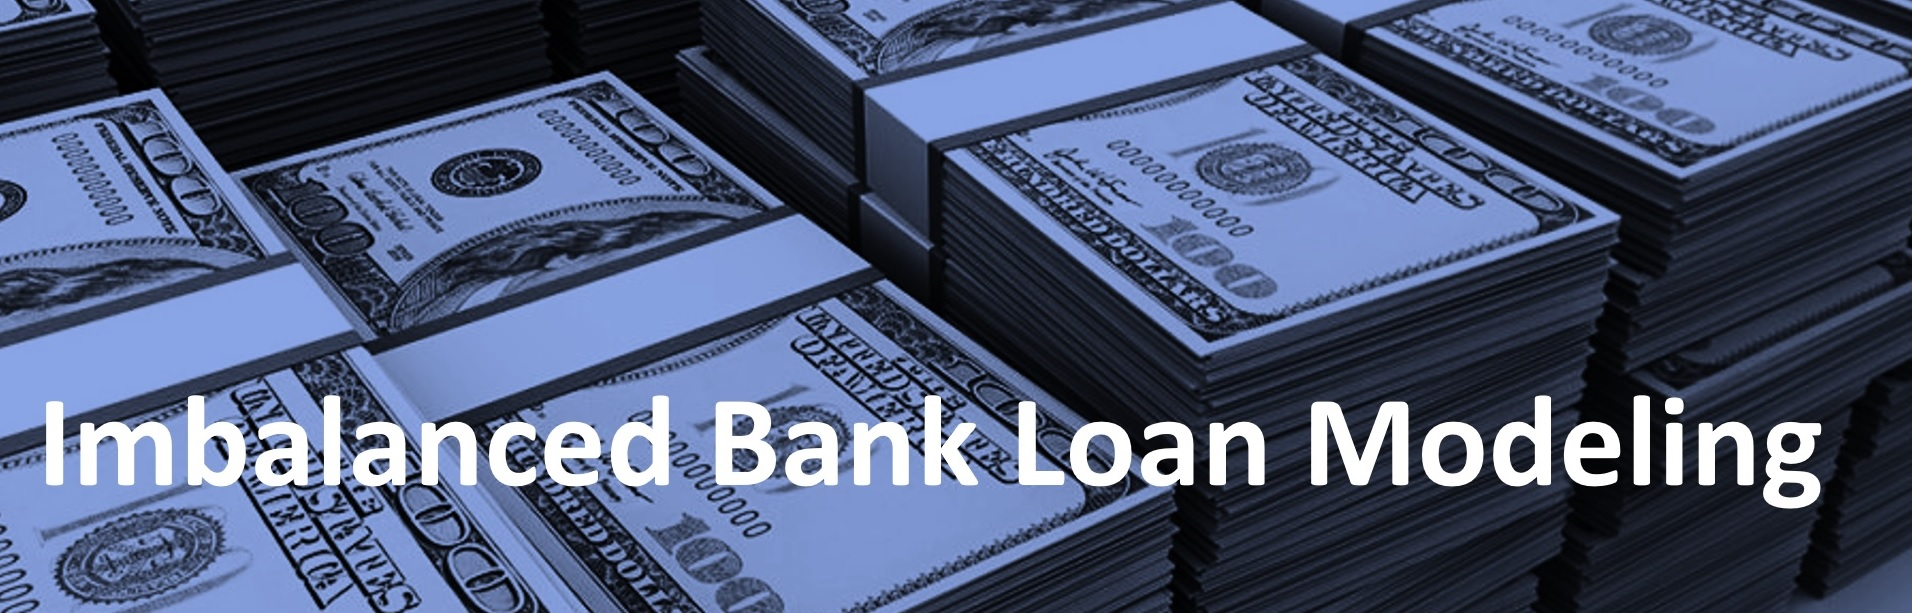

In this project, we will solve a problem for classifying personal loans on the __Thera-Bank dataset__. The majority of Thera-Bank's customers are depositors. The number of customers who are also borrowers (asset customers) is quite small, and the bank is interested in quickly expanding this base to do more loan business while earning more through loan interest. In particular, management wants to look for ways to convert its liability customers into retail loan customers while keeping them as depositors. A campaign the bank ran last year for deposit customers showed a conversion rate of over 9.6% success. This has prompted the retail marketing department to develop campaigns with better target marketing to increase the success rate with a minimal budget. The department would like to develop a classifier that will help them identify the potential customers who are more likely to purchase the loan. This will increase the success rate while reducing the cost of the campaign.

The dataset contains both customer information and customer response to the last personal loan campaign:

* __ID__: ID of the customer

* __Age__: Age of the customer in completed years

* __Experience__: Amount of work experience in years

* __Income__: Amount of annual income (in thousands)

* __Zipcode__: Postal code in which the client lives

* __Family__: Number of family members

* __CCAvg__: Average monthly spending with the credit card (in thousands)

* __Education__: Education level (1: bachelor's degree, 2: master's degree, 3: advanced/professional degree)

* __Mortgage__: Value of home mortgage, if any (in thousands)

* __Securities Account__: Does the customer have a securities account with the bank?

* __CD Account__: Does the customer have a certificate of deposit account (CD) with the bank?

* __Online__: Does the customer use the internet banking facilities?

* __CreditCard__: Does the customer use a credit card issued by the bank?

* __Personal Loan__: Did this customer accept the personal loan offered in the last campaign? (Target Variable)

__Objective:__ To use different classification models to predict the likelihood that a customer will buy a personal loan. 

__Let's get started:__

# Import Libraries

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from scipy import stats
%matplotlib inline

# Read Dataset

In [2]:
df = pd.read_excel('Bank_Personal_Loan_Modelling.xlsx', sheet_name='Data')
df.head(5)

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


_____________________________________________________
<h4 align="left"><font color='royalblue'>Dataset basic information:</font></h4>

* The dataset has data on __5000__ customers. 
* We have __14 variables__ including __13 independent variables__ and __1 dependent variable__ which is __Personal Loan__.
* We have __6 numeric variables__: ID , Age , Experience ,  Income  , CC_Avg , Mortgage
* We have __3 categorical variables__: Family , Education , Zip_Code
* We have __5 Boolean variables__: Personal_Loan , Securities Account , CD_Account , Online , Credit_Card
* The dataset contains negative values for the __Experience__, which is unreasonable.
* __ID__ lacks valuable information for the model.
* __ZIP Code__ contains a large number of categories (467 categories). Therefore, it seems it lacks much informaton for our model.

In [3]:
df.drop('ID', axis=1, inplace=True) 

# Correlation Analysis

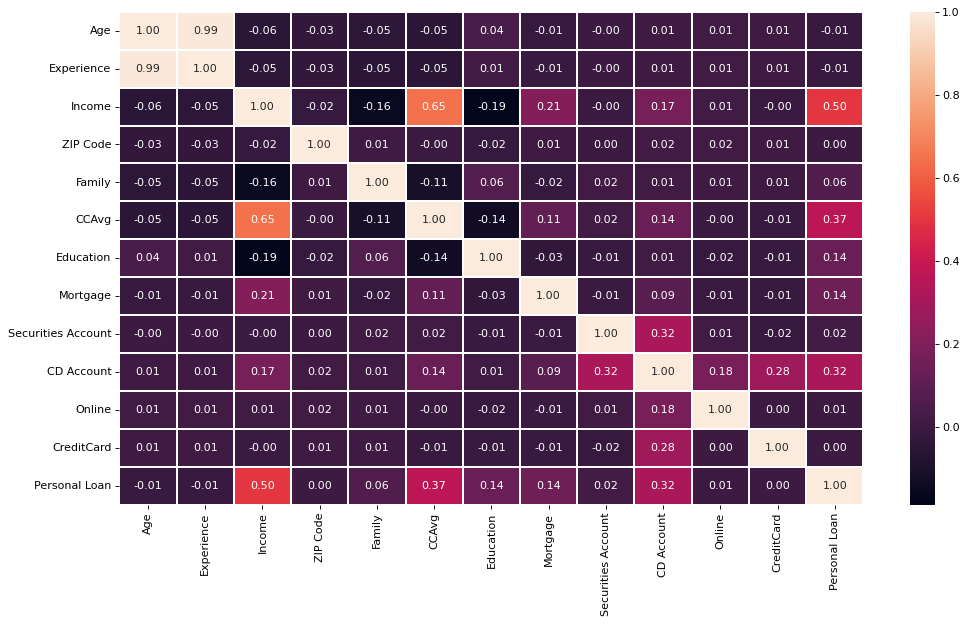

In [11]:
# Calculation of correlation
target = 'Personal Loan'
df_ordered = pd.concat([df.drop(target,axis=1), df[target]],axis=1)
corr = df_ordered.corr()

# Plot the heatmap correlation
plt.figure(figsize=(15,8), dpi=80)
sns.heatmap(corr, annot=True, fmt='.2f', linewidths=0.2)
plt.show()

<h4 align="left"><font color='midnightblue'>Conclusion:</font></h4>

* __Personal Loan__ is correlated with __Income, CD_Account, CCAvg__.
* __Experience__ is highly correlated with __Age__. (ρ = 0.99)
* __CCAvg__ is correlated with __Income__ to a good extent. (ρ = 0.55)

# Data Cleansing

In [14]:
df.drop('ZIP Code', axis=1, inplace=True)
df.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,25,1,49,4,1.6,1,0,0,1,0,0,0
1,45,19,34,3,1.5,1,0,0,1,0,0,0
2,39,15,11,1,1.0,1,0,0,0,0,0,0
3,35,9,100,1,2.7,2,0,0,0,0,0,0
4,35,8,45,4,1.0,2,0,0,0,0,0,1


As seen earlier, the dataset contains negative values for Experience. Considering that the values of this feature indicate work experience in years, these negative values are considered noise:

In [15]:
df[df['Experience']<0]['Experience'].count()

52

Count unique negative values:

In [16]:
df[df['Experience']<0]['Experience'].value_counts()

Experience
-1    33
-2    15
-3     4
Name: count, dtype: int64

Since the number of these noise values in the Experience feature is small, we assume that these values are incorrectly recorded as negative and replace them with their absolute value:

In [17]:
df['Experience'] = df['Experience'].apply(abs)

# Outlier Treatment

Let us look at the distribution of Mortgage:

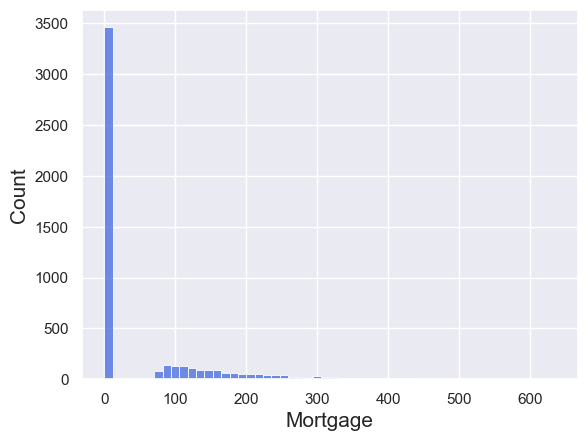

In [26]:
sns.histplot(x='Mortgage', data=df, color='royalblue')
plt.show()

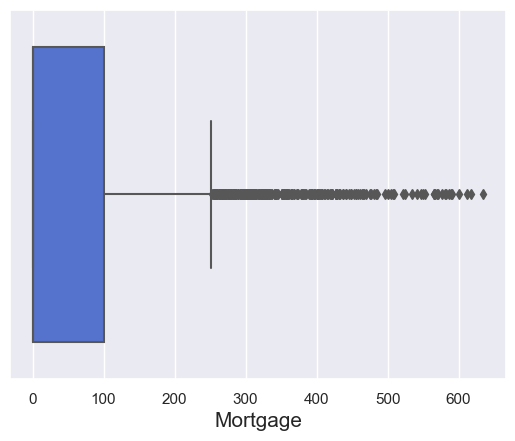

In [27]:
sns.boxplot(x='Mortgage', data=df, color='royalblue')
plt.show()

The __Z-score__ method for outlier detection is a statistical technique used to detect outliers from data sets by calculating how many standard deviations away from the mean each data point is. A data point with a Z score of more than 3 standard deviation away from the mean is considered an outlier. We use the __scipy.stats__ module to perform the zscore technique:

In [28]:
df[stats.zscore(df['Mortgage'])>3]['Mortgage'].count()

105

We found 105 records with a Z-score mortgage value greater than 3. Therefore, we consider these 105 records as outliers and filter out these records from our dataset:

In [29]:
outlier_indexes = df[stats.zscore(df['Mortgage'])>3].index
df.drop(outlier_indexes, inplace=True)
df.reset_index(drop=True, inplace=True)

# Missing Value Treatment

In [31]:
df.isnull().sum()

Age                   0
Experience            0
Income                0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64

It is clear that the dataset does not contain any missing values.

# Feature Transformation

In the dataset, CCAVG represents average monthly credit card spending, but Income represents the amount of annual income.
To make the units of the features equal, we convert average monthly credit card spending to annual:

In [34]:
df['CCAvg'] = df['CCAvg']*12

# Bivariate Analysis

In this part, we will create __100% stacked bar and column charts__ showing the proportion of purchased and non-purchased loans for each category of categorical features seprately:

In [35]:
# Define a list containing the names of important categorical features in the dataset 
Cat_Features = ['CD Account','Education','Family','Securities Account','Online','Securities Account']

# Define the target name in a variable for simplicity
Target = 'Personal Loan'

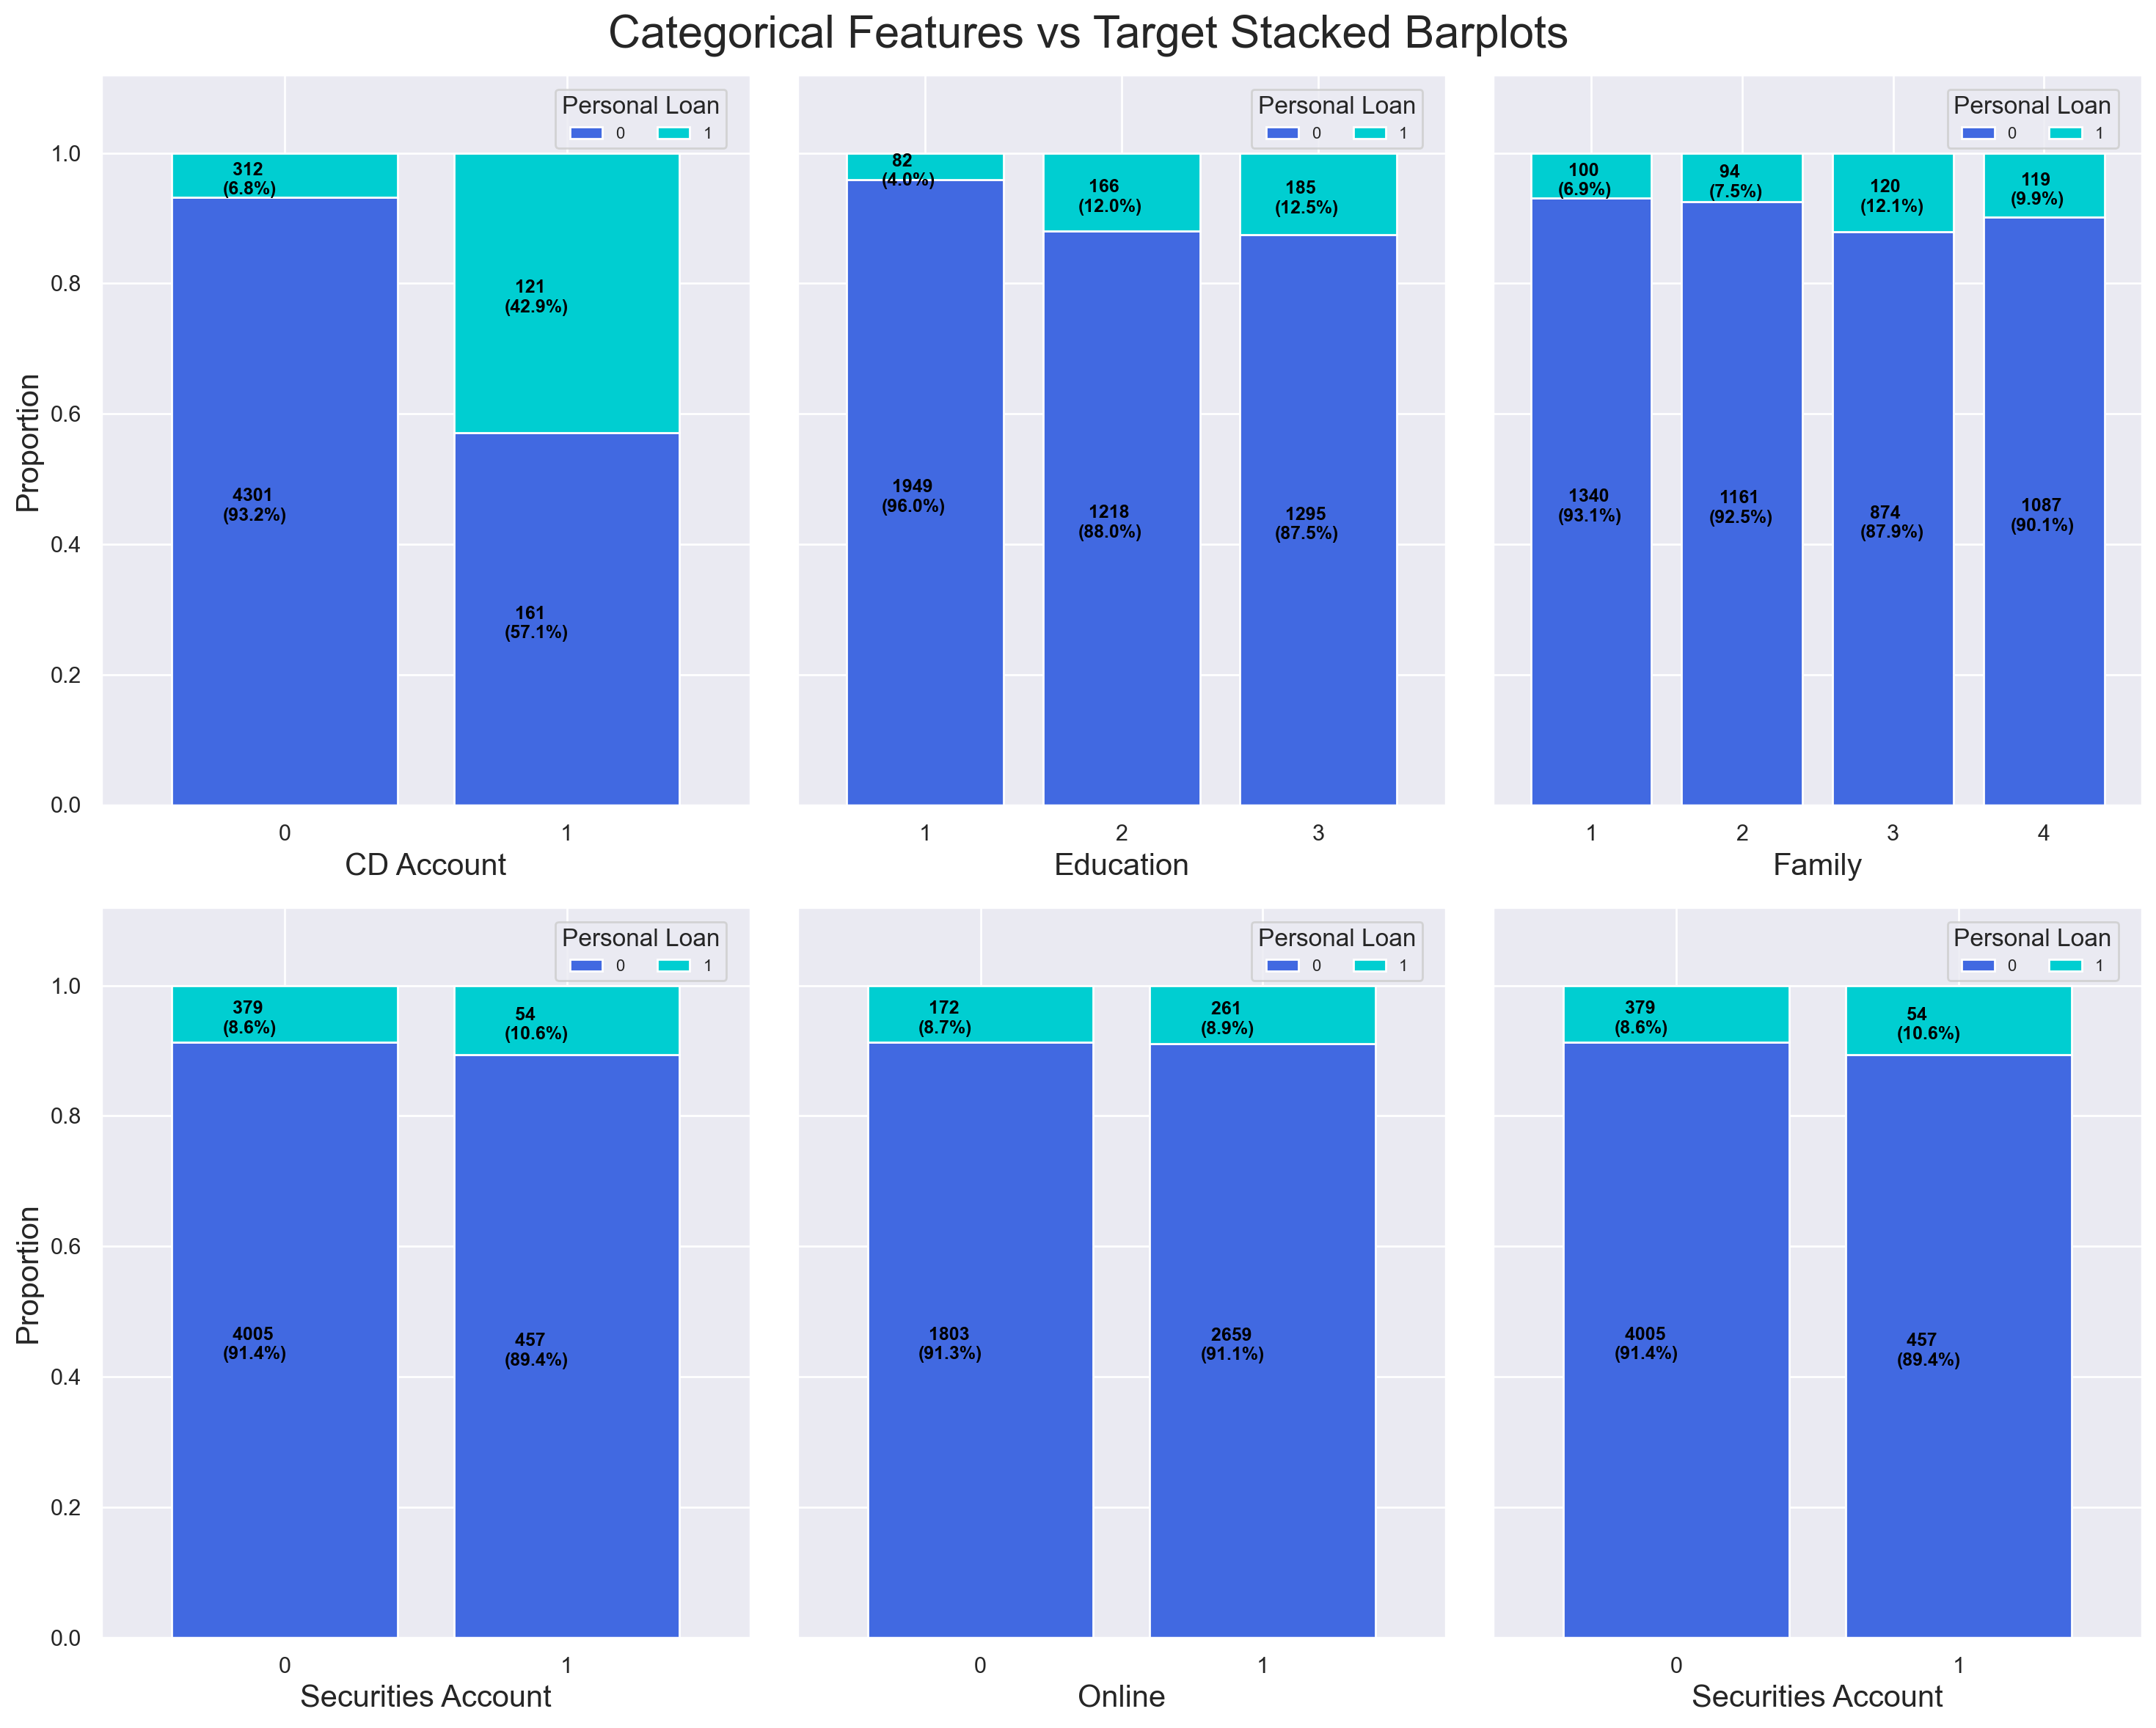

In [36]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,12), dpi=200)

for i,col in enumerate(Cat_Features):
    
    # Create a cross tabulation showing the proportion of purchased and non-purchased loans for each category of the feature
    cross_tab = pd.crosstab(index=df[col], columns=df[Target])
    
    # Using the normalize=True argument gives us the index-wise proportion of the data
    cross_tab_prop = pd.crosstab(index=df[col], columns=df[Target], normalize='index')

    # Define colormap
    cmp = ListedColormap(['royalblue', 'darkturquoise'])
    
    # Plot stacked bar charts
    x, y = i//3, i%3
    cross_tab_prop.plot(kind='bar', ax=ax[x,y], stacked=True, width=0.8, colormap=cmp,
                        legend=False, ylabel='Proportion', sharey=True)
    
    # Add the proportions and counts of the individual bars to our plot
    for idx, val in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_location) in zip(cross_tab_prop.loc[val],cross_tab.loc[val],cross_tab_prop.loc[val].cumsum()):
            ax[x,y].text(x=idx-0.22, y=(y_location-proportion)+(proportion/2)-0.03,
                         s = f'  {count}\n({np.round(proportion * 100, 1)}%)', 
                         color = "black", fontsize=9, fontweight="bold")
    
    # Add legend
    ax[x,y].legend(title='Personal Loan', loc=(0.7,0.9), fontsize=8, ncol=2)
    # Set y limit
    ax[x,y].set_ylim([0,1.12])
    # Rotate xticks
    ax[x,y].set_xticklabels(ax[x,y].get_xticklabels(), rotation=0)
            

plt.suptitle('Categorical Features vs Target Stacked Barplots', fontsize=22)
plt.tight_layout()                     
plt.show()

<h4 align="left"><font color='midnightblue'>Conclusion:</font></h4>

* The customer who has a certificate of deposit (CD) with the bank appears to buy personal loans from the bank.

* Customers with higher levels of education are more likely to buy personal loans.

* The number of family members has no significant effect on the probability of buying personal loans.

* Customers who have or do not have a securities account at the bank have no influence on the probability of buying a personal loan.

* The customer who uses or does not use internet banking does not seem to have any influence on the probability of buying a personal loan.

* The customer who uses or does not use a credit card does not appear to have an impact on the likelihood of purchasing a personal loan.

In this part, we will try to find the __mean__ and __distribution__ of numerical features for which customers purchase a personal loan versus the mean and distribution of numerical features who do not:

In [37]:
# Define a list containing the names of important numerical features in the dataset 
Num_Features = ['CCAvg','Income','Mortgage','Age','Experience']

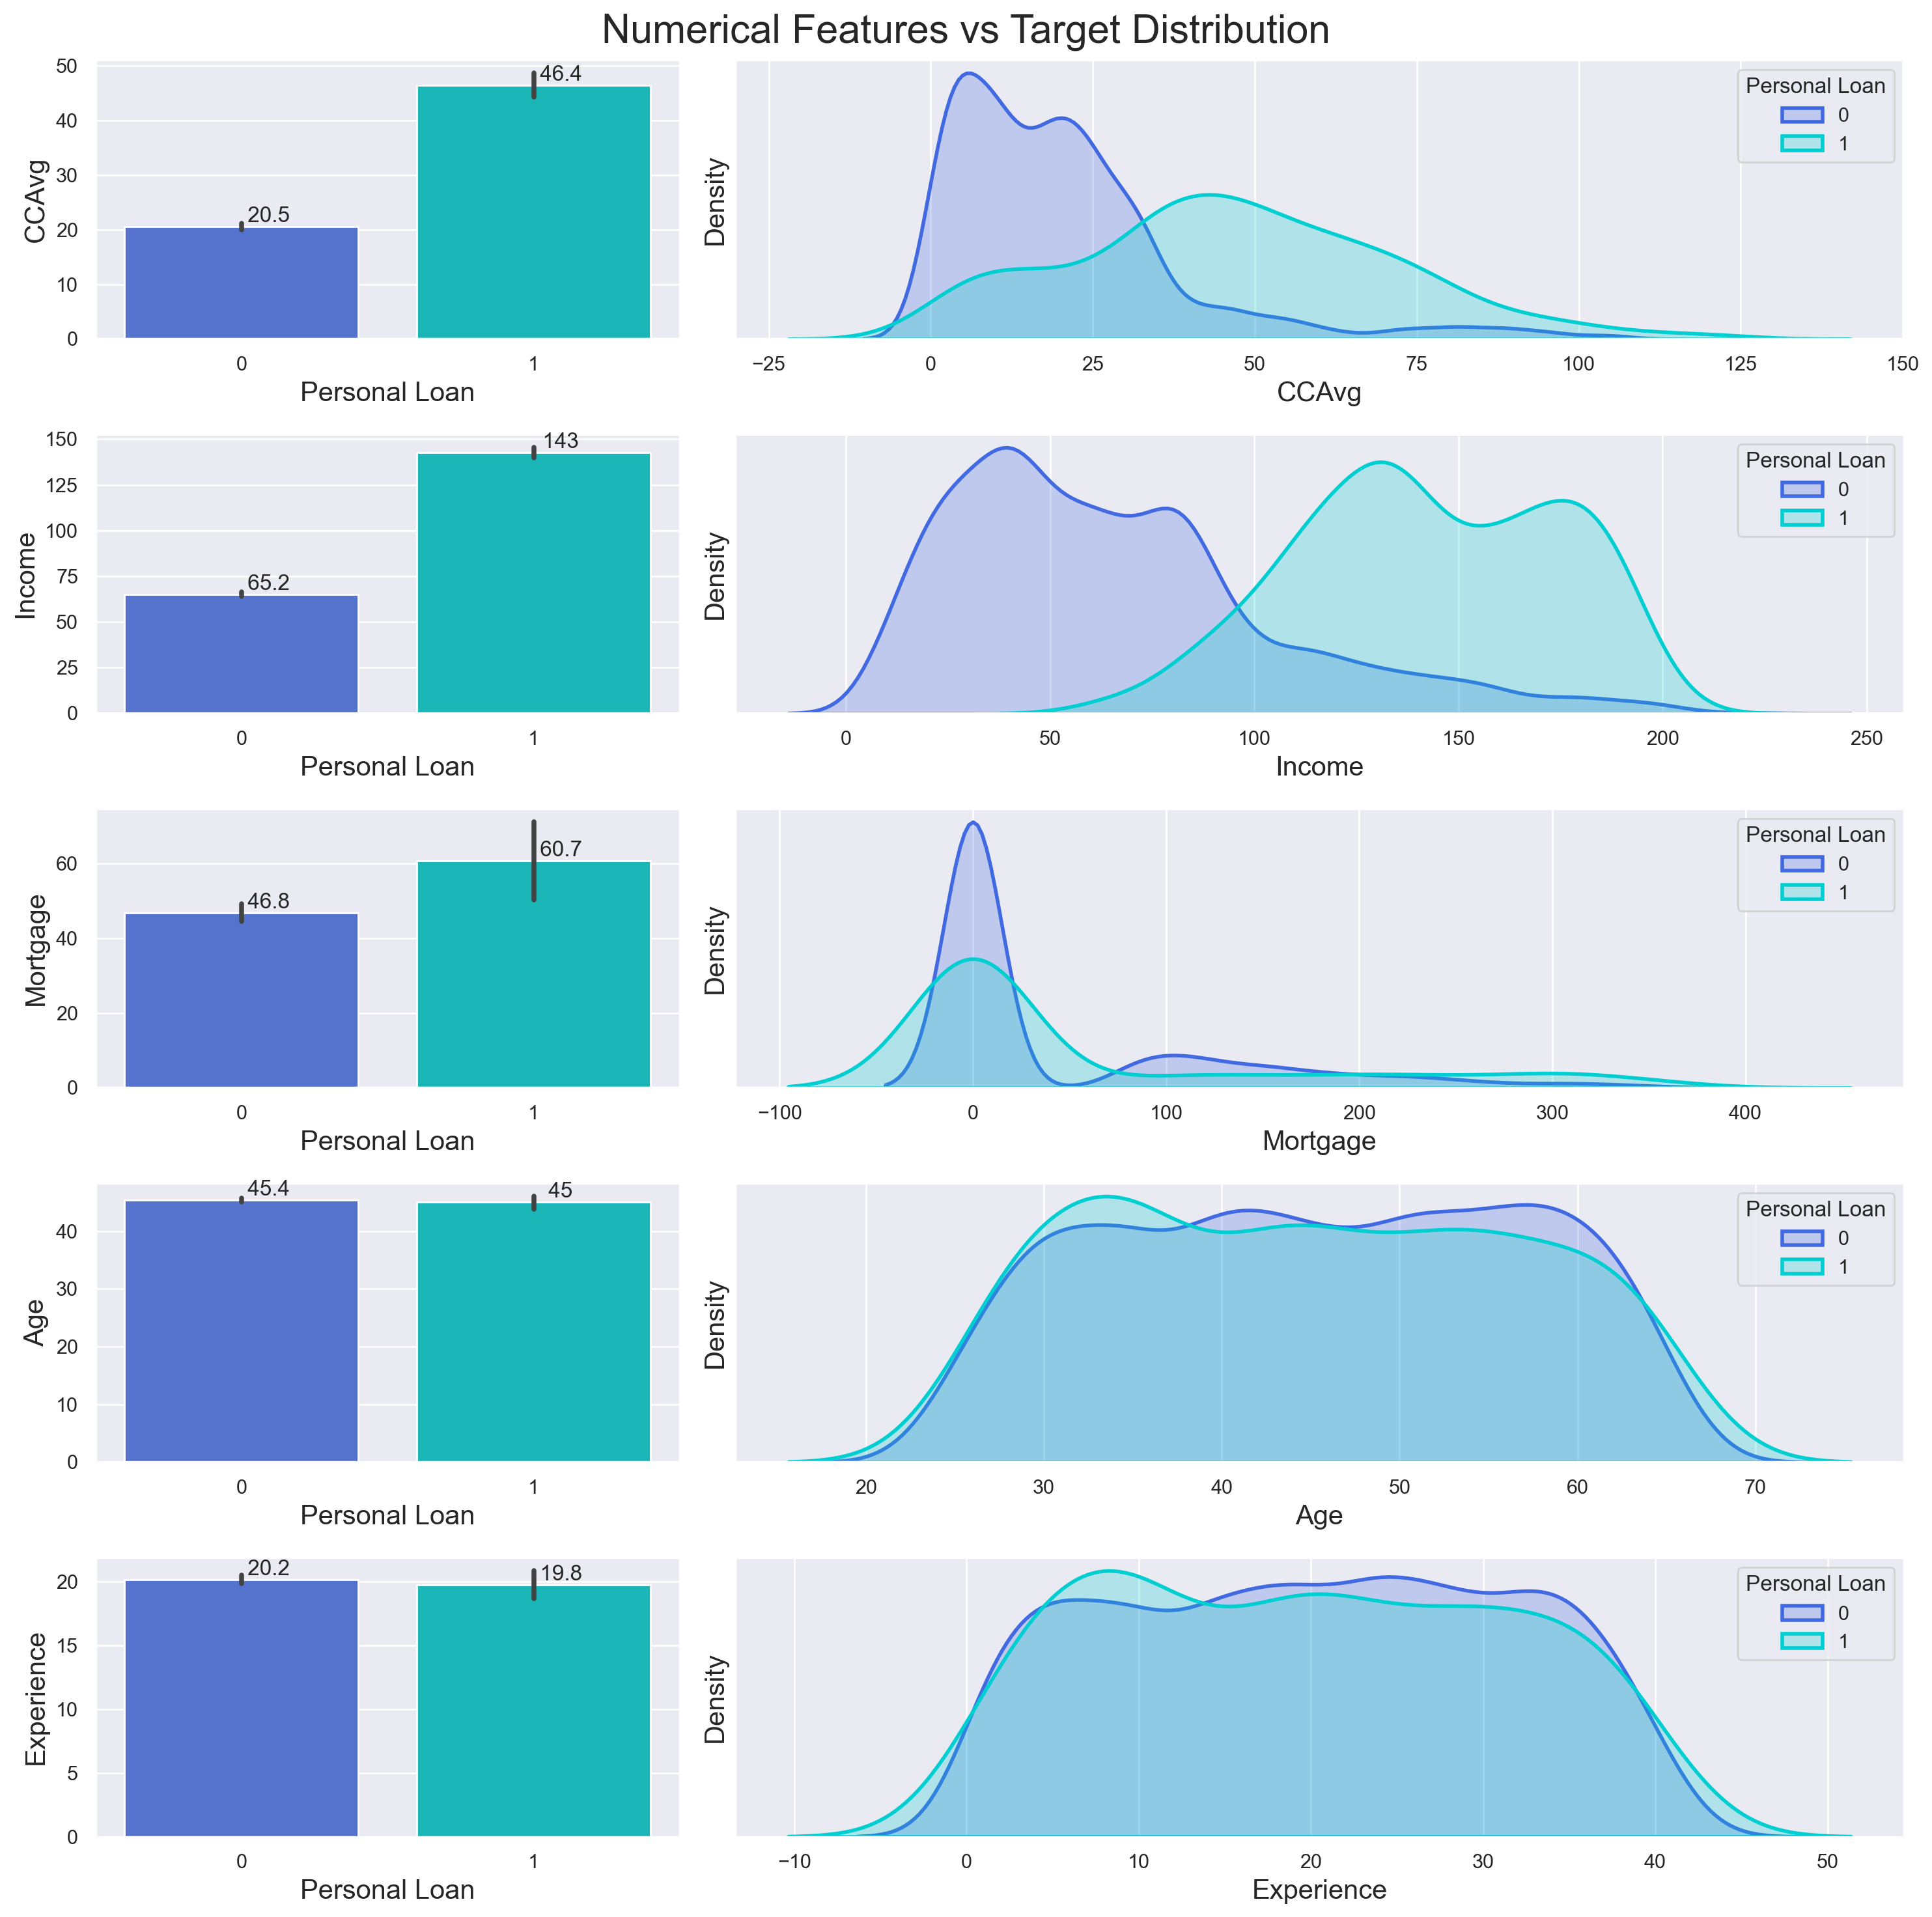

In [38]:
sns.set_palette(['royalblue', 'darkturquoise'])

fig, ax = plt.subplots(5, 2, figsize=(15,15), dpi=200, gridspec_kw={'width_ratios': [1, 2]})

for i,col in enumerate(Num_Features):
    # barplot
    graph = sns.barplot(data=df, x=Target, y=col, ax=ax[i,0])
    # kde Plot
    sns.kdeplot(data=df[df[Target]==0], x=col, fill=True, linewidth=2, ax=ax[i,1], label='0')
    sns.kdeplot(data=df[df[Target]==1], x=col, fill=True, linewidth=2, ax=ax[i,1], label='1')
    ax[i,1].set_yticks([])
    ax[i,1].legend(title='Personal Loan', loc='upper right')
    # Add bar sizes to our plot
    for cont in graph.containers:
        graph.bar_label(cont, fmt='         %.3g')
        
plt.suptitle('Numerical Features vs Target Distribution', fontsize=22)
plt.tight_layout()                     
plt.show()

<h4 align="left"><font color='midnightblue'>Conclusion:</font></h4>

* Customers who spend more on credit cards are more likely to take out personal loans.

* Customers with high incomes are more likely to purchase a personal loan.

* Customers with a high mortgage value are more likely to purchase personal loans.

* It can be inferred that the age of customers has no influence on the probability of purchasing personal loans.

* The effect of the amount of work experience on the purchase of a loan is similar to that of the age of the customer. The distribution of the Experience is very similar to the distribution of Age, as Experience is strongly correlated with Age.

>Therefore, we remove Experience because it doesn't provide any more information than Age:

In [39]:
df.drop('Experience', axis=1, inplace=True)

# Train Test Split

First of all, it is necessary to define the __features (X)__ and the output __labels (y)__ of the given dataset. X is a dataframe containing the different feature values for all given observations, while y is a series containing the categorical labels belonging to each observation:

In [40]:
X = df.drop('Personal Loan', axis=1)
y = df['Personal Loan'] 

____
<h2 align="left"><font color='midnightblue'>Imbalanced dataset:</font></h2>

Imbalanced dataset is a dataset where the classes are not balanced or equal. This means there are an unequal number of samples from each target class and some classes may have significantly more samples than others.

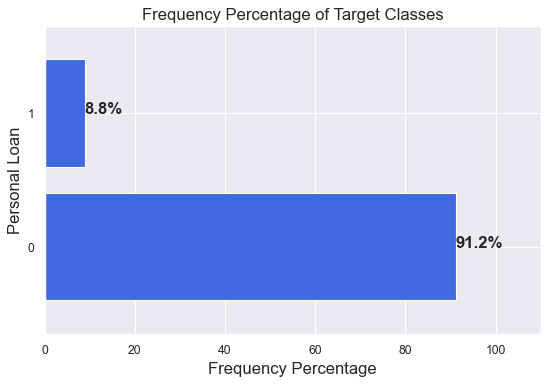

In [41]:
plt.figure(dpi=80)

# Plot frequency percentages barplot
df['Personal Loan'].value_counts(normalize=True).mul(100).plot(kind='barh', width=0.8, figsize=(8,5))

# Add frequency percentages to the plot
labels = df['Personal Loan'].value_counts(normalize=True).mul(100).round(1)
for i in labels.index:
    plt.text(labels[i], i, str(labels[i])+ '%', fontsize=15, weight='bold')

plt.xlim([0, 110])
plt.xlabel('Frequency Percentage', fontsize=15)
plt.ylabel('Personal Loan', fontsize=15)
plt.title('Frequency Percentage of Target Classes', fontsize=15)
plt.show()

As can be seen, __the dataset we are working on is imbalanced.__

____
<h2 align="left"><font color='midnightblue'>Problems with Imbalanced Datasets:</font></h2>

1. Imbalanced datasets can lead to algorithms that are biased towards the majority class. This means that any classification algorithm trained on an imbalanced dataset will often inaccurately classify minority classes as the majority class.


2. The performance of a machine learning model can become highly skewed when it is fed with imbalanced data. For example, our dataset has 91.2% class 0 and 8.8% class 1, then the learning model could be easily optimized to just predict all test input as belonging to class 0 and still get 91.2% accuracy!


3. If a model is trained on data which is heavily imbalanced, it can develop an incorrect understanding of the underlying trends in the data. The model may not be able to recognize how certain values are distributed among different classes or even how certain classes overlap with each other.

____
<h2 align="left"><font color='midnightblue'>Techniques to Handle Imbalanced Dataset:</font></h2>

<h3 align="left"><font color='royalblue'>1. The approach to train test split:</font></h3>

The approach to train test split when dealing with __imbalanced datasets__ is to use __stratification__. Stratification is an important step in splitting imbalanced datasets into training and test sets. Stratification ensures that the proportion of each class remains the same across both the training and test sets. This is important as it allows for a more accurate evaluation of the model, avoiding bias due to a disproportion of one class being over-represented in either dataset. Stratified sampling also ensures that any trends or correlations among different classes that exist within the overall dataset are preserved after splitting into training and test datasets:

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

Let's see the proportion of each class across both the training and test sets:

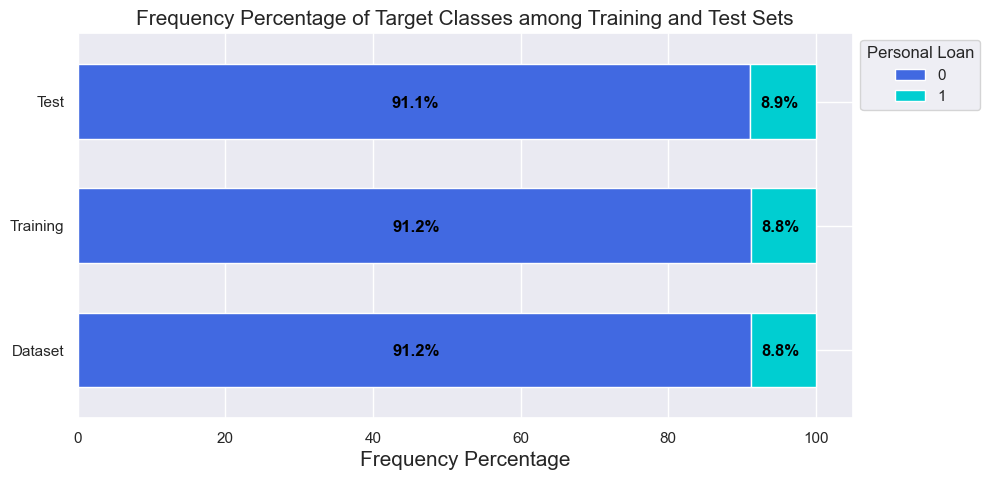

In [43]:
# Define a dataframe containing frequency percentages
df_perc = pd.concat([y.value_counts(normalize=True).mul(100).round(1),
                     y_train.value_counts(normalize=True).mul(100).round(1),
                     y_test.value_counts(normalize=True).mul(100).round(1)], axis=1)
df_perc.columns=['Dataset','Training','Test']
df_perc = df_perc.T

# Plot frequency percentages barplot
df_perc.plot(kind='barh', stacked=True, figsize=(10,5), width=0.6)

# Add the percentages to our plot
for idx, val in enumerate([*df_perc.index.values]):
    for (percentage, y_location) in zip(df_perc.loc[val], df_perc.loc[val].cumsum()):
        plt.text(x=(y_location - percentage) + (percentage / 2)-3,
                 y=idx - 0.05,
                 s=f'{percentage}%', 
                 color="black",
                 fontsize=12,
                 fontweight="bold")

plt.legend(title='Personal Loan', loc=(1.01,0.8))
plt.xlabel('Frequency Percentage', fontsize=15)
plt.title('Frequency Percentage of Target Classes among Training and Test Sets', fontsize=15)
plt.show()            

As seen, the samples are randomly divided in such a way that the proportion of each class remains the same across both the training and test sets. 

<h3 align="left"><font color='royalblue'>2. The approach for model evaluation:</font></h3>

The approach for __model evaluation__ when dealing with __imbalanced datasets__ is to use appropriate metrics including __recall, precision, F1 score and AUC(area under curve)__ that are better suited when dealing with imbalanced datasets instead of traditional accuracy metrics which don’t take into account class imbalance by default.

In this project, the main goal is to classify potential customers who are more likely to purchase a loan. The metrics used to evaluate the performance of the model will be important in determining how well the model is able to identify these potential customers.

* Recall is a measure of the proportion of actual positive cases that were correctly identified by the model. A high recall score means that the model has a low number of false negatives, which is desirable in this project because it means that the model is not missing many potential loan customers.

* Precision is a measure of the proportion of positive cases identified by the model that are actually positive. A high precision score means that the model has a low number of false positives, which is desirable in this project because it means that the model is not identifying many non-loan customers as potential loan customers.

* F1-score is a measure of the trade-off between recall and precision. It is calculated as the harmonic mean of recall and precision. A high F1-score indicates a balance between high recall and high precision.

__For this project, both recall and precision for class '1' are important metrics, so f1-score for class '1' should be considered as the most important metric. A high f1-score indicates a balance between identifying as many potential loan customers as possible (high recall) and minimizing the number of false positives (high precision). This is important for the bank, as it wants to increase the conversion rate of depositors to borrowers while reducing the cost of the marketing campaign.__

<h3 align="left"><font color='royalblue'>3. Approaches for model building:</font></h3>

> <h3 align="left"><font color='midnightblue'>I) Data-based approaches:</font></h3>
>
>* __Random undersampling__: Undersampling involves randomly removing instances from the majority class to reduce its size.
>    * __Cons__: Information loss caused by discarding the majority of the training set.
>
>
>* __Random oversampling__: It involves adding additional copies of instances from the minority class to make it more equal in size.
>    * __Cons__: Overfitting, which is caused by replicating observations from the minority class.
> 
>
>* __SMOTE__: SMOTE (Synthetic Minority Oversampling Technique) is an oversampling technique that creates new, synthetic observations from the minority class. This way, the algorithm avoids the problem of overfitting encountered with random oversampling.
>
>    * __Cons__: Since SMOTE randomly creates rows of new data, the newly created synthetic samples lack real value information, thus leading to a potential decrease in accuracy overall. In addition, if there are natural boundaries between classes such as overlapping classes, additional outliers may be created due to the artificial creation of data points through SMOTE.

> <h3 align="left"><font color='midnightblue'>II) Model-based approaches:</font></h3>
>
> * __Penalize Algorithms__: Penalize algorithms by giving more weight to a specific classification label, making correct classification of the minority class more important than correct classification of the majority class during optimisation process.
>
>
> * __Use Tree-Based Algorithms__: Tree-based algorithms like Random Forest, Extra Trees Classifiers and XGBoost can naturally handle imbalanced data because they make decisions based on a majority vote among randomized decision trees and do not require balancing classes before training.


# Logistic Regression Model Building

__Logistic Regression__ is a type of supervised machine learning algorithm used for binary classification problems. It models the probability of a target variable (usually binary) as a function of input features, using a logistic function (sigmoid) to map predictions between 0 and 1. The model is trained using labeled data to optimize the coefficients of the features to minimize the prediction error.

Before building our logistic classifier, we will apply __Standard Scaler__ to our data.

__Standard Scaler__ is used to scale the data. It transforms the data by subtracting the mean and dividing by the standard deviation, ensuring that all features have a similar range of values.

In [44]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [45]:
# Scale the training and test data using the same scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert training and test sets from numpy array to pandas dataframes
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

__Note:__ It is very important that StandardScaler transformation should only be learnt from the training set, otherwise it will lead to data leakage.

__Hyperparameter tuning__ can affect the performance of a logistic regression model by allowing it to find the best combination of hyperparameters that result in the lowest error on the training set. This can lead to improved prediction performance and reduced overfitting. However, if not done, it can lead to overfitting on the validation set, resulting in a model that is not generalizable to new data.

Also, since our dataset is imbalanced, we intend to make the correct classification of the minority class more important than the correct classification of the majority class in the optimization process, which is called __penalizing__ the model. We do this by giving more weight to the minority class. Therefore, the weights of the classes are hyperparameters whose optimal value is also determined during the Hyperparameter tuning process.

In [59]:
# Define hyperparameters grid
param_grid = [{'solver':['lbfgs', 'newton-cg', 'sag', 'saga'],
              'penalty': ['l1', 'l2'], 
               'C': [0.001, 0.01, 0.1, 1, 10, 100]}]

We use GridSearchCV to find the optimal combination of hyperparameters that gives the best performance on the training data:

We will define a function in which the optimal combination of hyperparameters that will cause the best __f1-score__ value for the model will be discovered. For this reason, we define a function so that it can be used to tune the hyperparameters of future models as well:

In [60]:
def tune_clf_hyperparameters(clf, param_grid, X_train, y_train):
    '''
    This function optimize the hyperparameters for a classifier by searching over a specified hyperparameter grid. It uses 
    GridSearchCV and cross-validation (StratifiedKFold) to evaluate different combinations of hyperparameters, and selects  
    the combination with the highest f1-score. The function returns the best classifier with the optimal hyperparameters.
    '''
    
    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    # Create the GridSearchCV object
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring='f1', n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    print("Best hyperparameters:\n", clf_grid.best_params_)
    
    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_

We use the above function to find the optimal combination of hyperparameters for logistic regression classifier:

In [63]:
# Define the base model
logreg = LogisticRegression(max_iter=1000)

# Call tune_clf_hyperparameters function to find the optimal combination of hyperparameters 
logreg_opt = tune_clf_hyperparameters(logreg, param_grid, X_train, y_train)

Best hyperparameters:
 {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}


These are the optimal hyperparameter values for the Logistic Regression model. logreg_opt is the Logistic Regression model whose hyperparameters have been set to the optimal values.

Let's evaluate the Logistic Regression model performance using model_evaluation function:

In [70]:
def metrics_calculator(clf, X_test, y_test, model_name):
    '''
    This function calculates all desired performance metrics for a given model on test data.
    '''
    y_pred = clf.predict(X_test)
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, average='binary'),
                                recall_score(y_test, y_pred, average='binary'),
                                f1_score(y_test, y_pred, average='binary'),
                                roc_auc_score(y_test, clf.predict_proba(X_test)[::,1])],
                          index=['Accuracy','Precision','Recall','F1-score','AUC'],
                          columns = [model_name])
    
    result = (result * 100).round(2).astype(str) + '%'                            
    return result

In [74]:
def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name):
    '''
    This function provides a complete report of the model's performance including classification reports, 
    confusion matrix and ROC curve.
    '''
    sns.set(font_scale=1.2)
    
    # Generate classification report for training set
    y_pred_train = clf.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Generate classification report for test set
    y_pred_test = clf.predict(X_test)
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    
    # Create figure and subplots 
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=100, gridspec_kw={'width_ratios': [2, 2, 1]})
    
    # Plot confusion matrix for test set
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False, ax=ax1)
    ax1.set_title('Confusion Matrix for Test Data')                                     
    ax1.grid(False)
    
    # Plot ROC curve for test data and display AUC score 
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax2)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve for Test Data (Positive label: 1)')
    
    # Report results for the class specified by positive label
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax3.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 2)
    table.set_fontsize(12)
    ax3.axis('tight')
    ax3.axis('off')
    # Modify color 
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color('royalblue')
    plt.tight_layout()
    plt.show() 


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3570
           1       0.84      0.63      0.72       346

    accuracy                           0.96      3916
   macro avg       0.90      0.81      0.85      3916
weighted avg       0.95      0.96      0.95      3916


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       892
           1       0.78      0.59      0.67        87

    accuracy                           0.95       979
   macro avg       0.87      0.79      0.82       979
weighted avg       0.94      0.95      0.95       979



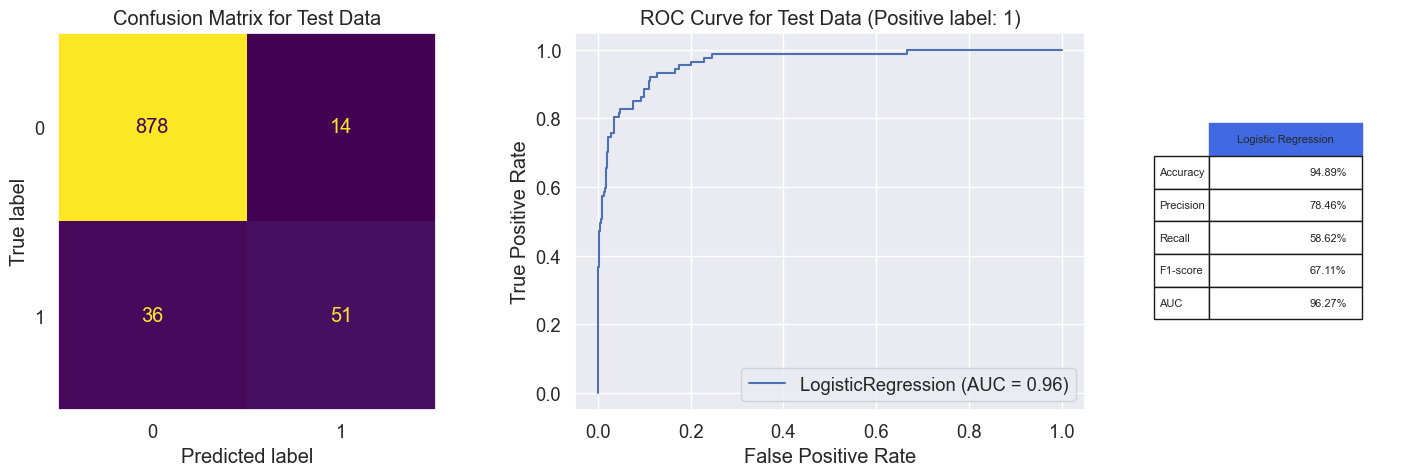

In [75]:
model_evaluation(logreg_opt, X_train, X_test, y_train, y_test, 'Logistic Regression')

In [76]:
# Save the final performance of Logistic Regression classifier
logreg_result = metrics_calculator(logreg_opt, X_test, y_test, 'Logistic Regression')

# Decision Tree Model Building

A Decision Tree is a tree-based supervised learning algorithm that can be used for classification or regression tasks. It works by recursively splitting the data into subsets based on the values of the features, with the goal of minimizing a cost function, such as Gini impurity or entropy.

<h4 align="left"><font color='midnightblue'>Advantages:</font></h4>

* __Easy to understand and interpret:__ Decision Trees are simple to understand and visualize.

* __Handles both numerical and categorical data:__ Decision Trees can handle both numerical and categorical data.

* __Feature selection:__ Decision Trees can be used for feature selection, as important features will appear near the root of the tree.

* __Non-parametric:__ Decision Trees are non-parametric, meaning that they make no assumptions about the underlying distribution of the data.


<h4 align="left"><font color='midnightblue'>Disadvantages:</font></h4>

* __Overfitting:__ Decision Trees can be prone to overfitting, especially with deep trees or with small training sets. This can result in poor generalization to new data.

* __Instability:__ Small changes in the data can result in large changes in the tree, making Decision Trees unstable.

* __Bias towards features with many categories:__ Decision Trees can be biased towards features with many categories, as they may dominate the construction of the tree.

* __Poor approximation of complex functions:__ Decision Trees may not be suitable for approximating complex functions, as they are limited by the axis-parallel splits at each node.

__Note:__ Decision Trees do not require standard scaling of the data before model building. Standard scaling is typically used for algorithms that are sensitive to the scale of the input features, such as distance-based algorithms like KNN and SVM.

__Decision Tree__ classifiers are prone to overfitting. This occurs when the tree is too complex and fits the training data too closely, capturing even the noise in the data.


<h4 align="left"><font color='midnightblue'>Ways to prevent overfitting in decision tree classifiers:</font></h4>

* __Pruning:__ Removing branches of the tree that do not contribute much to the classification.
* __Using ensemble methods:__ Combining multiple decision trees to obtain a more robust model.
* __Limiting tree size:__ Setting a minimum number of samples required to split an internal node or a maximum depth for the tree.

<h4 align="left"><font color='midnightblue'>The following are the most common hyperparameters for Decision Tree Classifiers:</font></h4>

>* __Criterion:__ This hyperparameter determines the criterion used to measure the quality of a split. Commonly used criteria are "Gini Impurity" and "Information Gain".
>
>* __Maximum depth:__ This hyperparameter controls the maximum depth of the tree. The deeper the tree, the more complex it becomes, which can lead to overfitting. Setting a maximum depth can prevent overfitting by limiting the size of the tree.
>
>* __Minimum samples per split:__ This hyperparameter sets the minimum number of samples required to split an internal node. If the number of samples at a node is less than this value, the node cannot be split further. This can also prevent overfitting by limiting the size of the tree.
>
>* __Minimum samples per leaf:__ This hyperparameter sets the minimum number of samples required for a leaf node. If a leaf node has fewer samples than this value, it can be removed.
>
>* __Maximum features:__ This hyperparameter determines the maximum number of features to consider when splitting a node. It is used to prevent overfitting by reducing the complexity of the model.
>
>* __Class_weight:__ Weights associated with classes.


Again we define our hyperparameters grid using the above hyperparameteres and then call tune_clf_hyperparameters function to find the best combination:

In [78]:
# Define the hyperparameter grid
param_grid = {'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': np.arange(1, 10),
              'min_samples_split': np.arange(1, 10),
              'min_samples_leaf': np.arange(1, 10),
              'max_features': [None, 'sqrt', 'log2']} 

Let's call tune_clf_hyperparameters function for hyperparameter tuning:

In [79]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Create a  Decision Tree Classifier object
dt = DecisionTreeClassifier(random_state=0)

# Find the best classifier with the optimal hyperparameters
dt_opt = tune_clf_hyperparameters(dt, param_grid, X_train, y_train)

Best hyperparameters:
 {'criterion': 'gini', 'max_depth': 6, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 8}


Let's evaluate our final Decision Tree classifier performance using model_evaluation function:


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3570
           1       0.96      0.92      0.94       346

    accuracy                           0.99      3916
   macro avg       0.97      0.96      0.97      3916
weighted avg       0.99      0.99      0.99      3916


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       892
           1       0.94      0.91      0.92        87

    accuracy                           0.99       979
   macro avg       0.97      0.95      0.96       979
weighted avg       0.99      0.99      0.99       979



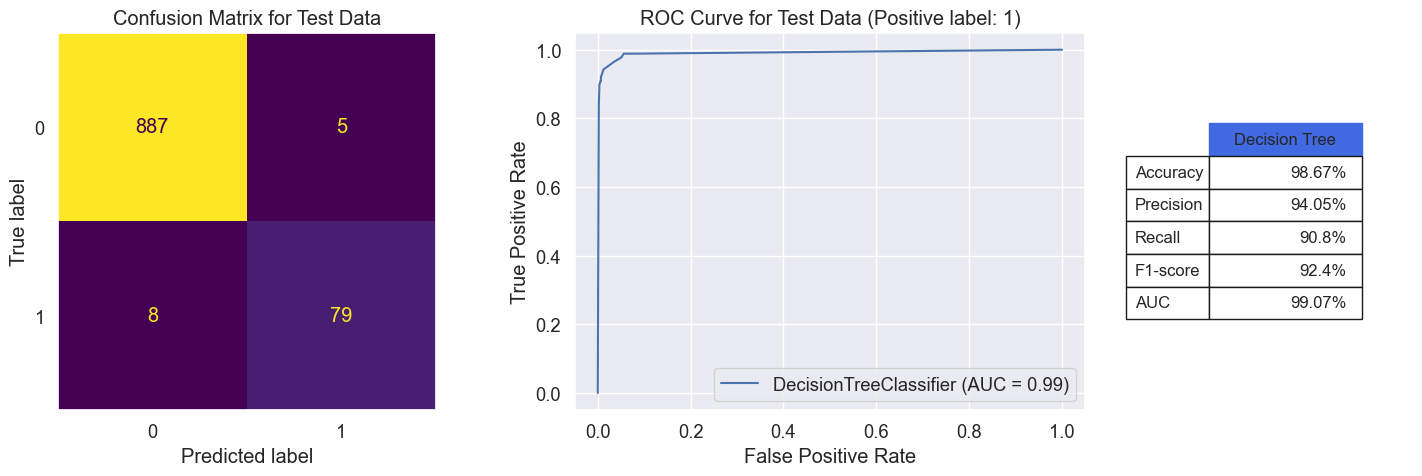

In [80]:
model_evaluation(dt_opt, X_train, X_test, y_train, y_test, 'Decision Tree')

For the decision tree classifier, we got 92% f1-score. If we examine the confusion matrix out of 979 bank customers, the models made errors in 13 cases to predict whether the customer accepts the loan or not.

In [81]:
# Save the final performance of Decision Tree classifier
dt_result = metrics_calculator(dt_opt, X_test, y_test, 'Decision Tree')

# Ensemble Learning

__Ensemble learning__ is a machine learning technique that combines the predictions of multiple models to make more accurate and robust predictions. The idea behind ensemble learning is that by combining several models, or weak learners, to solve the same problem, the resulting ensemble model can perform better than any individual model. There are three main ensemble learning methods: 

* __Bagging__ stands for bootstrapped aggregating. In bagging, multiple instances of the same base model are trained in parallel on different bootstrapped samples of the data, and the results are aggregated through an averaging operation. Bagging is best suited for base models with low bias but high variance, as the averaging operation reduces the variance of the final ensemble model.


* __Boosting__ is an iterative technique where multiple instances of the same base model are trained sequentially. At each iteration, the current weak learner is trained based on the previous weak learners and how well they performed on the data. Boosting is best suited for base models with low variance but high bias, as the iterative strategy of learning reduces the bias of the final ensemble model.


* __Stacking__ is a technique where different base models are trained independently, and a meta-model is trained on top of that to predict outputs based on the outputs of the base models. In stacking, the base models are used as features for the meta-model, which makes the final predictions based on the combined information from all the base models.

<h4 align="left"><font color='royalblue'>DTs are often used as base models in ensemble methods because they have several properties that make them well-suited for this purpose:</font></h4>

1. __Simple and easy to understand:__ Decision trees are simple and easy to understand, which makes them a good choice for use as base models in ensemble methods.

2. __Handle non-linear relationships:__ Decision trees can handle non-linear relationships between features and target variables, which makes them a good choice for modeling complex datasets.

3. __Handle missing values and outliers:__ Decision trees are able to handle missing values and outliers in the data, which is important for real-world datasets that often have such problems.

4. __Can capture interactions between features:__ Decision trees can capture interactions between features, which is important for capturing complex relationships in the data.

5. __Fast to train and make predictions:__ Decision trees are fast to train and make predictions, which makes them well-suited for use in large-scale machine learning models.

6. __Provide feature importance:__ Decision trees provide feature importance, which can be useful for understanding which features are contributing the most to the predictions made by the model.

<h3 align="left"><font color='midnightblue'>The most important bagging models based on decision tree classifier are:</font></h3>

* __Random Forest:__ Random forests are an ensemble learning method that utilizes decision trees as its base model. The trees in a random forest are grown on bootstrapped samples of the training data and a randomly selected subset of features. This helps reduce the correlation between the trees and makes the model more robust to missing data. The goal of random forests is to lower the variance of the model by combining multiple deep decision trees. The combination of bagging and random feature subspace selection results in a more robust and accurate model compared to individual decision trees.


* __Extra Trees:__ Extra trees are an extension of random forests that use random splits instead of optimizing the splits based on information gain or other criteria. This makes extra trees faster to train than random forests and less prone to overfitting.

<h3 align="left"><font color='midnightblue'>The most important boosting models are:</font></h3>

* __Adaboost:__ This is one of the earliest and most popular boosting algorithms. It trains a series of weak decision trees and assigns more weight to the misclassified samples in each iteration.


* __Gradient Boosting:__ This is a general purpose boosting algorithm that works well with a variety of weak models, including decision trees. It uses the gradient descent optimization method to minimize the loss function and find the best combination of weak models.


* __XGBoost:__ This is an optimized implementation of gradient boosting and one of the most widely used algorithms in the machine learning community. It is known for its fast training speed, scalability, and ability to handle large datasets.


* __LightGBM:__ This is another optimized implementation of gradient boosting that is designed for large datasets and has been widely adopted in industry.

# Random Forest Model Building

__Random Forest__ is an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. The trees in a random forest are grown from randomly selected samples of the training data and a subset of the features. It reduces overfitting and improving its stability by combining multiple trees and hence the name "Forest".

Tuning the hyperparameters of a Random Forest classifier can improve its performance on a given problem. The hyperparameters control the complexity and behavior of the model, and their values can have a significant impact on the model's accuracy and generalization ability. For example, setting the maximum depth of the trees too high can result in overfitting, while setting it too low can result in underfitting. The same is true for other hyperparameters such as the minimum number of samples required to split a node, or the number of features considered when splitting a node. Tuning the hyperparameters helps to find the best combination of values that result in the best performance on the particular problem being solved. 

<h3 align="left"><font color='midnightblue'>The hyperparameters of a Random Forest classifier are:</font></h3>

> * __n_estimators:__ The number of trees in the forest.
>
> * __criterion:__ The function to measure the quality of a split. Common criteria include Gini impurity and information gain.
>
> * __max_depth:__ The maximum depth of a tree. This can be used to control the complexity of the model and prevent overfitting.
>
> * __min_samples_split:__ The minimum number of samples required to split an internal node.
>
> * __min_samples_leaf:__ The minimum number of samples required to be at a leaf node.
>
> * __bootstrap:__ Whether or not to sample with replacement when building the trees in the forest.
>
> * __oob_score:__ Whether or not to use out-of-bag samples to estimate the generalization accuracy.
>
> * __class_weight:__ Weights associated with classes.
>
> * __max_features:__ The maximum number of features to consider when splitting a node. This can be set as a number or a float (percentage) or 'sqrt' or 'log2'.

We set the range of values for each hyperparameter that we want to consider for our Random Forest classifier, and then use tune_clf_hyperparameters function to find the best combination of hyperparameters that provides the best results:

__Note:__ Trees that compose a forest can either be __shallow__, meaning they have a limited number of branches or levels, or __deep__, meaning they have many branches or levels and are not fully grown. __Deep trees__ have __low bias__ but __high variance__ and, so, are relevant choices for __bagging methods__ that is mainly focused at __reducing variance__. We consider to have deep trees in choosing the range of values for random forest hyperparameters.

In [82]:
# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100, 150], 
    'max_depth': np.arange(5, 12),
    'min_samples_split': [1, 2, 3],
    'min_samples_leaf': [1, 2, 3]}

Let's call tune_clf_hyperparameters function for hyperparameter tuning:

In [83]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Create a random forest classifier object
rf = RandomForestClassifier(criterion='gini', max_features=None, bootstrap=True, random_state=0)

# Find the best classifier with the optimal hyperparameters
rf_opt = tune_clf_hyperparameters(rf, param_grid, X_train, y_train)

Best hyperparameters:
 {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


Let's evaluate our optimal Random Forest classifier performance using model_evaluation function:


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3570
           1       1.00      0.99      1.00       346

    accuracy                           1.00      3916
   macro avg       1.00      1.00      1.00      3916
weighted avg       1.00      1.00      1.00      3916


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       892
           1       0.93      0.91      0.92        87

    accuracy                           0.99       979
   macro avg       0.96      0.95      0.96       979
weighted avg       0.99      0.99      0.99       979



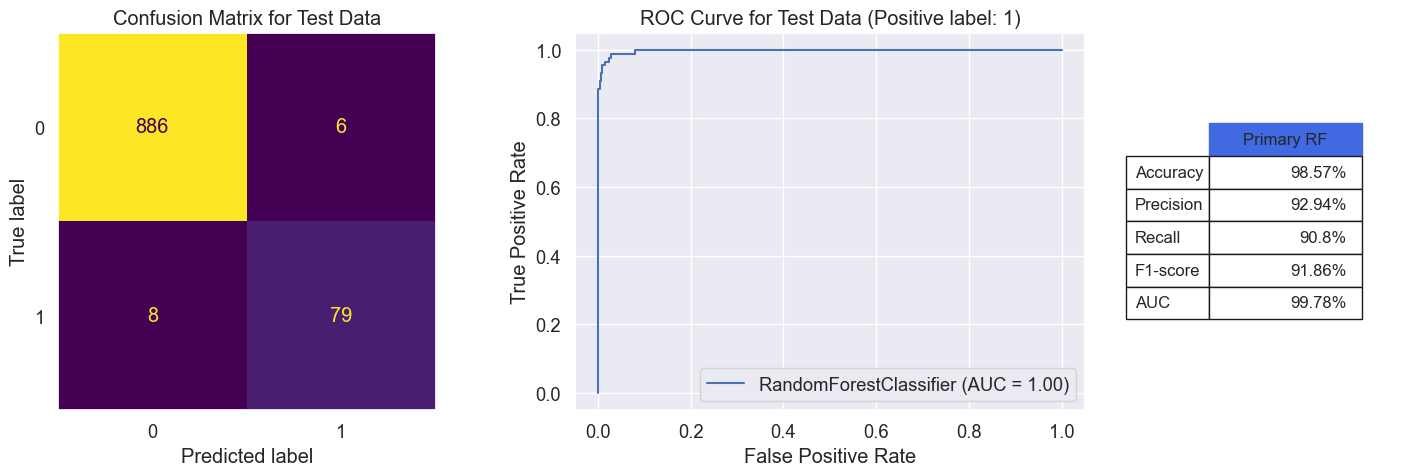

In [84]:
model_evaluation(rf_opt, X_train, X_test, y_train, y_test, 'Primary RF')

If we compare the values of precision, recall and f1-score for class 1 (more important class) on both training and test sets, we see a slight decrease in the scores on the test dataset compared to training, which shows that the model is fairly overfit.
Overfitting of the model is due to its high variance, and in the following, we try to release the model from overfitting by applying a small change in the value of hyperparameters, hoping that the performance of the model will improve on the test data.

<h4 align="left"><font color='royalblue'>How do each of these Random Forest classifier hyperparameters increase model variance?</font></h4>

> * __n_estimators__ - Increasing the number of trees in the forest will increase the variance, as more trees in the forest can capture more diverse patterns in the data.
>
> * __max_depth__ - Increasing the maximum depth of a tree allows the tree to capture more complex patterns in the data, increasing its variance.
>
> * __min_samples_split__ - Decreasing the minimum number of samples required to split an internal node will increase the variance as it allows for more splits to occur.
>
> * __min_samples_leaf__ - Decreasing the minimum number of samples required to be at a leaf node will increase the variance as it allows for smaller leaves to form.
>
> * __max_features__ - Increasing the maximum number of features to consider when splitting a node will increase the variance as it allows for more diverse sets of features to be considered when splitting.
>
> * __bootstrap__ - Sampling with replacement when building the trees in the forest will increase the variance as it allows for more diverse sets of samples to be used for each tree.

Among the optimal values obtained for hyperparameters, we only increase the value of __min_samples_leaf__ from 2 to 6 in order to partially reduce the variance of the model:

In [85]:
# Build random forest classifier object considering the obtained optimal values for hyperparameters
rf_final = RandomForestClassifier(criterion='gini', max_features=None, bootstrap=True,  n_estimators=100, 
                                  max_depth = 9,  min_samples_leaf=6, min_samples_split=2, random_state=0)
                             
                            
# Train the final Random Forest model
rf_final.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, max_features=None, min_samples_leaf=6,
                       random_state=0)

Let's evaluate our Random Forest classifier again:


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3570
           1       0.97      0.91      0.94       346

    accuracy                           0.99      3916
   macro avg       0.98      0.95      0.97      3916
weighted avg       0.99      0.99      0.99      3916


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       892
           1       0.96      0.90      0.93        87

    accuracy                           0.99       979
   macro avg       0.98      0.95      0.96       979
weighted avg       0.99      0.99      0.99       979



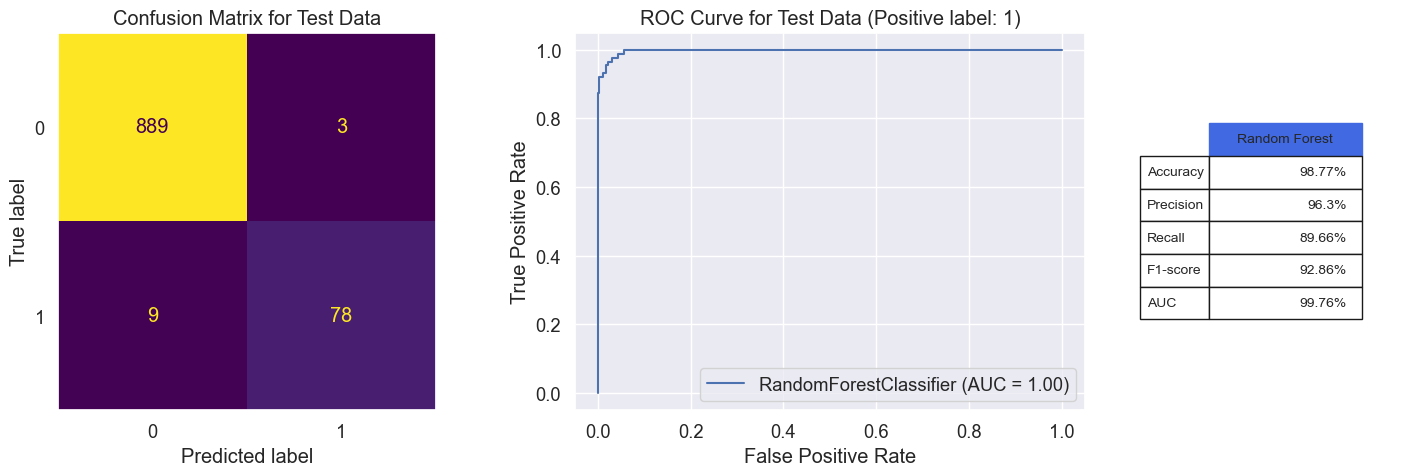

In [86]:
model_evaluation(rf_final, X_train, X_test, y_train, y_test, 'Random Forest')

We got the remarkable 94% f1-score with 99.81% AUC for our Random Forest classifier. Out of 979 bank customers, the model made errors just in 12 cases to predict whether the customer accepts the loan or not.

In [87]:
# Save the final performance of Random Forest classifier
rf_result = metrics_calculator(rf_final, X_test, y_test, 'Random Forest')

# AdaBoost Model Building

__AdaBoost (Adaptive Boosting)__ is a popular boosting ensemble learning algorithm that is used for classification and regression tasks. It combines multiple "weak" classifiers to create a strong classifier that makes accurate predictions. The weak classifiers are trained one by one and the algorithm adjusts the weights of the training instances based on their misclassification rates. The idea behind AdaBoost is to focus on the samples that are misclassified by the previous weak classifiers, so that the subsequent weak classifiers can do a better job in classifying those samples. In this way, the algorithm tries to improve the overall accuracy of the classifier by combining the outputs of multiple weak classifiers.

The term "weak classifier" refers to a simple classifier that is not highly accurate, but when combined with other weak classifiers, results in a strong overall classifier. Typically, decision trees are used as the weak classifiers in AdaBoost. However, any machine learning algorithm that accepts weights on the training data can be used as the base learner in AdaBoost.

Hyperparameter tuning is generally necessary for most machine learning algorithms, including the AdaBoost classifier. It can help to optimize the performance of the model and avoid overfitting or underfitting.

<h3 align="left"><font color='midnightblue'>The hyperparameters of the AdaBoost classifier include:</font></h3>

> * __learning rate:__ This parameter determines the contribution of each weak learner in the final prediction. A lower learning rate results in a slower convergence, but a more accurate prediction.
>
> * __number of estimators:__ This is the maximum number of weak learners that will be used to create the final strong classifier. A larger number of estimators can lead to a more accurate prediction, but it also increases the computation time.
>
> * __estimator:__ The algorithm used for the weak learner can be selected based on the problem at hand. We choose Decision Tree.

__Note:__ In addition to the hyperparameters of the AdaBoost classifier, such as the learning rate, number of estimators, and sampling strategy, the hyperparameters of the base estimator also need to be optimized to achieve the best performance. Shallow trees have high bias but low variance and, so, are relevant choices for boosting methods that are mainly focused at reducing bias. Shallow trees allow the boosting algorithm to focus on samples that are difficult to classify.

We set the range of values for each hyperparameter that we want to consider for our AdaBoost classifier, and then use tune_clf_hyperparameters function to find the best combination of hyperparameters that provides the best results:

In [88]:
# Define the hyperparameter grid for AdaBoost
ada_param_grid = {
    'base_estimator__max_depth': [3, 5, 7],
    'base_estimator__min_samples_split': [3, 5, 7],
    'base_estimator__min_samples_leaf': [1, 2, 3],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.8, 0.9, 1]
}

Let's call tune_clf_hyperparameters function for hyperparameter tuning:

In [89]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Create the Decision Tree classifier as the base estimator
dt = DecisionTreeClassifier(criterion='gini', max_features=None, random_state=0)

# Create the AdaBoost classifier using Decision Tree as base estimator
ada = AdaBoostClassifier(base_estimator=dt, random_state=0)

# Find the best AdaBoost classifier with the optimal hyperparameters
ada_opt = tune_clf_hyperparameters(ada, ada_param_grid, X_train, y_train)

Best hyperparameters:
 {'base_estimator__max_depth': 5, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 3, 'learning_rate': 0.8, 'n_estimators': 50}


Let's evaluate our optimal AdaBoost classifier performance using model_evaluation function:


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3570
           1       1.00      1.00      1.00       346

    accuracy                           1.00      3916
   macro avg       1.00      1.00      1.00      3916
weighted avg       1.00      1.00      1.00      3916


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       892
           1       0.99      0.93      0.96        87

    accuracy                           0.99       979
   macro avg       0.99      0.96      0.98       979
weighted avg       0.99      0.99      0.99       979



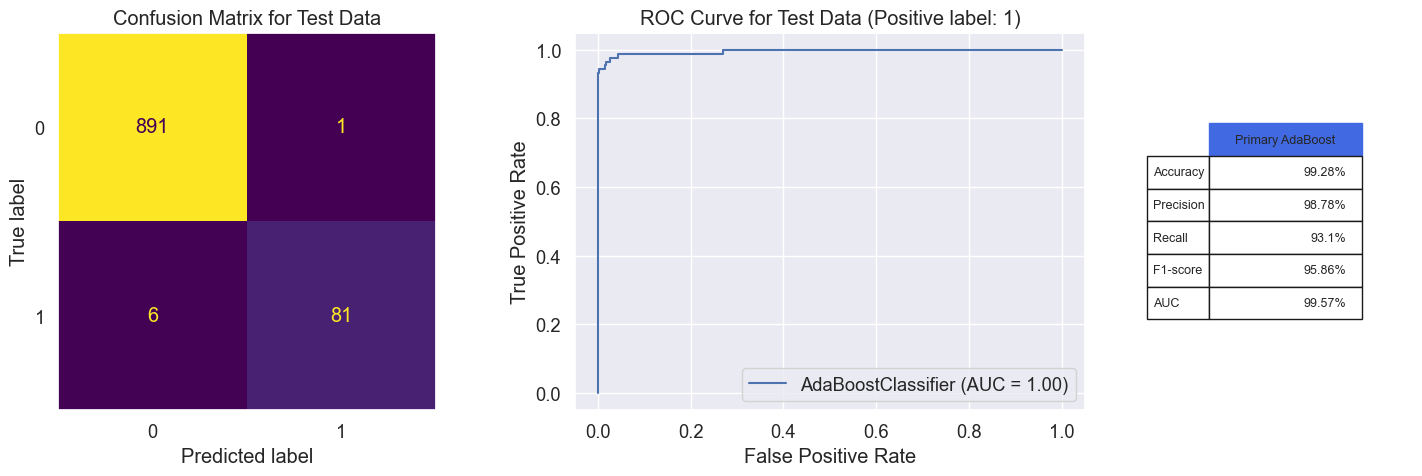

In [90]:
model_evaluation(ada_opt, X_train, X_test, y_train, y_test, 'Primary AdaBoost')

Performance metrics for the minority class on the test data show that the model is not overfitting completely, but may not be the best model for the problem. Overfitting of the classifier is due to its high variance, and to avoid overfitting, we can try regularization techniques, which means applying a small change in the value of hyperparameters to reduce the variance of the classifier.

<h4 align="left"><font color='royalblue'>How to reduce our AdaBoost classifier variance by tuning model hyperparameters?</font></h4>

> * __Decrease the number of trees in the model:__ AdaBoost uses multiple weak learners (in this case decision trees) to build a strong model. Decreasing the number of trees in the model can reduce model variance.
>
> * __Decrease the maximum depth of the decision trees:__ Decreasing the maximum depth of the decision trees can reduce model variance.
>
> * __Increase the minimum number of samples required to split an internal node:__ Increasing the minimum number of samples required to split an internal node can reduce model variance.
>
> * __Increase the minimum number of samples required to be at a leaf node:__ Increasing the minimum number of samples required to be at a leaf node can reduce model variance.
>
> * __Decrease the learning rate:__ The learning rate in AdaBoost determines the weight that each weak learner is given. Decreasing the learning rate can make the model less prone to overfitting.


Among the optimal values obtained for hyperparameters, we only decrease the value of learning_rate from 0.9 to 0.8 in order to partially reduce the variance of the model:

In [91]:
# Create the Decision Tree classifier as the base estimator
dt = DecisionTreeClassifier(criterion='gini', max_features=None, random_state=0, max_depth=5, min_samples_leaf=2, min_samples_split=5)

# Create the AdaBoost classifier using Decision Tree as base estimator
ada_final = AdaBoostClassifier(base_estimator=dt, random_state=0, learning_rate=0.8, n_estimators=100)

# Train the final AdaBoost classifier
ada_final.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                         min_samples_leaf=2,
                                                         min_samples_split=5,
                                                         random_state=0),
                   learning_rate=0.8, n_estimators=100, random_state=0)

Let's evaluate our final AdaBoost classifier:


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3570
           1       1.00      1.00      1.00       346

    accuracy                           1.00      3916
   macro avg       1.00      1.00      1.00      3916
weighted avg       1.00      1.00      1.00      3916


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       892
           1       0.98      0.92      0.95        87

    accuracy                           0.99       979
   macro avg       0.98      0.96      0.97       979
weighted avg       0.99      0.99      0.99       979



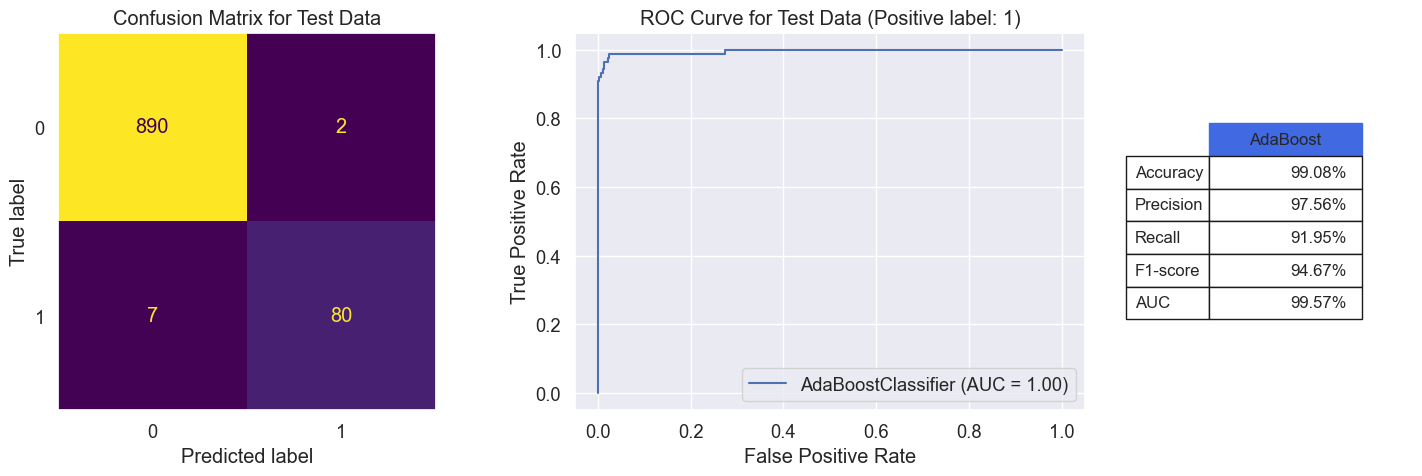

In [92]:
model_evaluation(ada_final, X_train, X_test, y_train, y_test, 'AdaBoost')

The variance of the model is reduced and thus the performance of the model on the test data is improved. Since the difference in scores on the test and training data is not large and the AUC score is high, we can ignore it. The f1-score obtained on the test data is almost the same as the previous bagging models.

__Note:__ The __AUC (Area Under Curve)__ metric measures the performance of a binary classifier by plotting the true positive rate against the false positive rate and calculating the area under the curve. A model that is not overfit will have a high AUC, close to 1, indicating that it has a good balance between true positive and false positive predictions. A model that is overfitting, on the other hand, may have a high accuracy on the training set but a lower AUC on the validation set, as it may be making many false positive predictions. Hence, a high AUC score suggests that the model is not overfitting and has good generalization performance on new, unseen data.

In [93]:
# Save the final performance of AdaBoost classifier
ada_result = metrics_calculator(ada_final, X_test, y_test, 'AdaBoost')

# Gradient Boosting Model Building

__Gradient Boosting__ is an ensemble machine learning technique for classification and regression problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise manner, where each subsequent model tries to correct the mistakes of the previous model. The algorithm iteratively trains decision trees in such a way that the trees are able to fit the negative gradient of the loss function being optimized. The final prediction is made by combining the outputs of all the individual trees. 

__Note :__ The implementation of Gradient Boosting Classifier in scikit-learn's ensemble module (sklearn.ensemble.GradientBoostingClassifier) is based on decision tree as the base estimator. 

Tuning the hyperparameters of Gradient Boosting is important. The hyperparameters can significantly impact the model performance, and finding the optimal set of hyperparameters is crucial for achieving good results. An inappropriate setting of hyperparameters can lead to underfitting or overfitting, and affect the model's ability to generalize to unseen data.

<h3 align="left"><font color='midnightblue'>The hyperparameters of Gradient Boosting Classifier include:</font></h3>

> * __n_estimators:__ The number of trees in the ensemble.
>
> * __learning_rate:__ The learning rate shrinks the contribution of each tree by a factor of learning_rate. It is a parameter to control the magnitude of update, and the value should be set lower for a large number of trees.
>
> * __max_depth:__ The maximum depth of the individual decision trees. The deeper the tree, the more splits it has and the more complex the model becomes.
>
> * __min_samples_split:__ The minimum number of samples required to split an internal node.
>
> * __min_samples_leaf:__ The minimum number of samples required to be at a leaf node.
>
> * __max_features:__ The number of features to consider when looking for the best split.
>
> * __subsample:__ The fraction of samples to be used for fitting the individual base learners.
>
> * __loss:__ The loss function to be optimized. The default loss function is ‘deviance’ which refers to logistic regression for binary classification and multinomial deviance for multi-class classification problems.
>
> * __criterion:__ The function to measure the quality of a split. Supported criteria are “friedman_mse” for mean squared error, which is used for regression problems, and “entropy” or “gini” for the information gain, which is used for classification problems.

We again set the range of values for each hyperparameter that we want to consider for our Gradient Boosting classifier, and then use tune_clf_hyperparameters function to find the best combination of hyperparameters that provides the best results:

Since hyperparameter tuning on the above grid can be very time-consuming due to the large size of the grid, after executing it at once and knowing the optimal values , we make the set of grid values smaller:

In [95]:
# Define the hyperparameter grid for tuning
gbc_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [4, 5, 6],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'subsample': [0.9, 1.0],
    'learning_rate': [0.3, 0.4, 0.5]
}

Let's call tune_clf_hyperparameters function for hyperparameter tuning:

In [97]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Initialize the Gradient Boosting Classifier
gbc = GradientBoostingClassifier(max_features=None, loss='log_loss', criterion='friedman_mse', random_state=0)

# Find the best hyperparameters from the tuning process
gbc_opt = tune_clf_hyperparameters(gbc, gbc_param_grid, X_train, y_train)

Best hyperparameters:
 {'learning_rate': 0.4, 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 50, 'subsample': 0.9}


Let's evaluate our optimal Gradient Boosting classifier performance using model_evaluation function:


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3570
           1       1.00      1.00      1.00       346

    accuracy                           1.00      3916
   macro avg       1.00      1.00      1.00      3916
weighted avg       1.00      1.00      1.00      3916


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       892
           1       0.94      0.93      0.94        87

    accuracy                           0.99       979
   macro avg       0.97      0.96      0.97       979
weighted avg       0.99      0.99      0.99       979



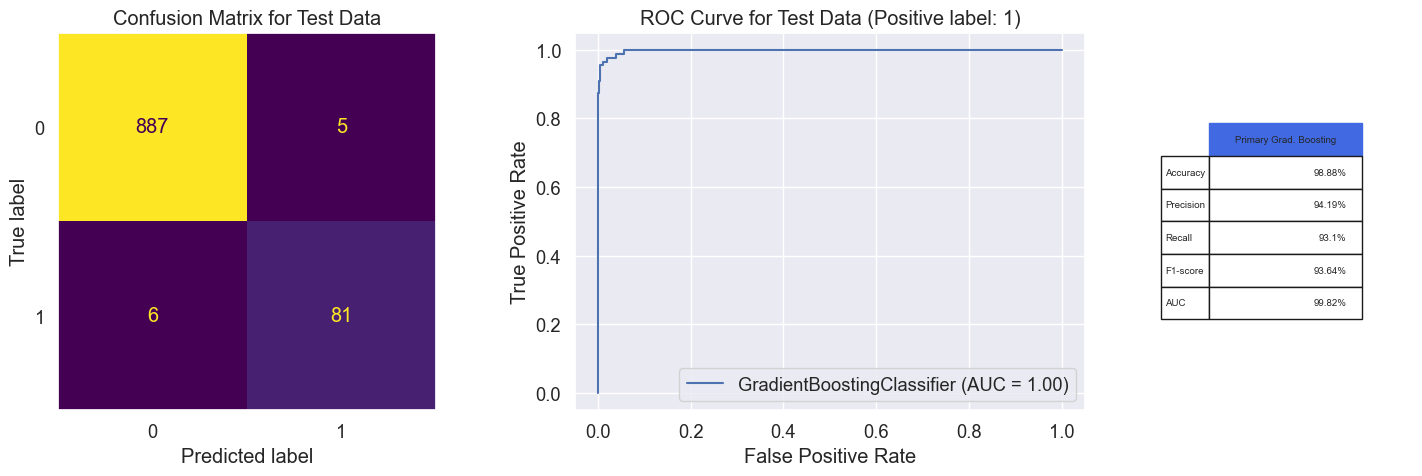

In [101]:
model_evaluation(gbc_opt, X_train, X_test, y_train, y_test, 'Primary Grad. Boosting')

Our Gradient Boosting classifier is fairly overfit on the minority class. Therefore, agian we need to reduce the variance of the classifier by slightly changing the value of hyperparameters.

<h4 align="left"><font color='royalblue'>How to reduce our Gradient Bossting classifier variance by tuning model hyperparameters?</font></h4>

> * __Number of Trees:__ We can reduce the number of trees to reduce model variance. More trees means more complex models, which are more prone to overfitting.
>
> * __Maximum Depth of Trees:__ We can reduce the maximum depth of trees in the model, which will reduce model variance by limiting the number of splits.
>
> * __Learning Rate:__ Decreasing the learning rate will reduce the magnitude of the updates to the model parameters, making it harder for the model to overfit the training data.
>
> * __Subsampling:__ can subsample the training data by taking a smaller sample of it during each iteration of the model training. This will prevent overfitting by introducing randomness into the model.
>
> * __Tree-Specific Hyperparameters:__ We can reduce the variance of the model by adjusting hyperparameters specific to decision trees. For exmale we can increase the minimum number of samples required to split a node or the minimum number of samples in a leaf.

Among the optimal values obtained for hyperparameters, we only decrease the value of learning_rate from 0.4 to 0.2 in order to partially reduce the variance of the model:

In [102]:
# Initialize the Gradient Boosting Classifier
gbc_final = GradientBoostingClassifier(max_features=None, loss='log_loss', criterion='friedman_mse',
                                 learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0,
                                 min_samples_leaf=4, min_samples_split=2, random_state=0)

# Train the final AdaBoost classifier
gbc_final.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, max_depth=5, min_samples_leaf=4,
                           random_state=0)

Let's evaluate our final Gradient Boosting classifier:


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3570
           1       1.00      1.00      1.00       346

    accuracy                           1.00      3916
   macro avg       1.00      1.00      1.00      3916
weighted avg       1.00      1.00      1.00      3916


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       892
           1       0.95      0.93      0.94        87

    accuracy                           0.99       979
   macro avg       0.97      0.96      0.97       979
weighted avg       0.99      0.99      0.99       979



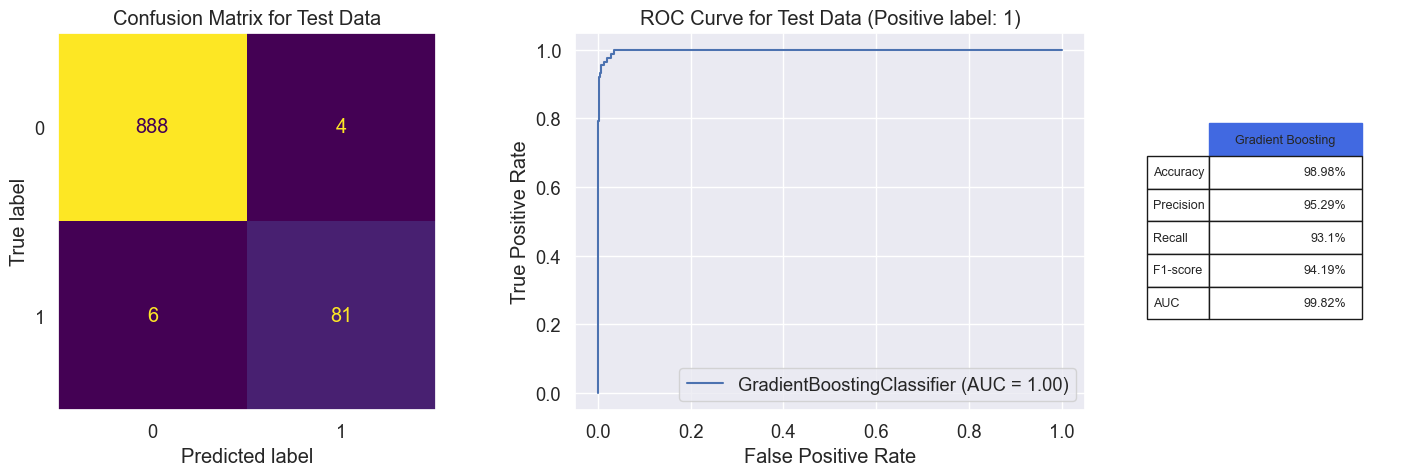

In [103]:
model_evaluation(gbc_final, X_train, X_test, y_train, y_test, 'Gradient Boosting')

The variance of the model is reduced and thus we got the brilliant 94% f1-score with 99.82% AUC for our Gradient Boosting classifier which is the best performance among all the classifiers reviewed till now. Out of 979 bank customers, the model made errors just in 10 cases to predict whether the customer accepts the loan or not. Let us unveil our ultimate weapon now: __XGBoost Classifier !__

In [105]:
# Save the final performance of Gradient Boosting classifier
gbc_result = metrics_calculator(gbc_final, X_test, y_test, 'Gradient Boosting')

# XGBoost Model Building

__XGBoost__ is a type of gradient boosting algorithm for tree-based machine learning models. It stands for __eXtreme Gradient Boosting__. XGBoost is a highly optimized implementation of gradient boosting and is designed to be fast and memory efficient.

<h4 align="left"><font color='midnightblue'>XGBoost has several unique features compared to other gradient boosting implementations, such as:</font></h4>

* Handling missing values
* Parallel processing for training and prediction
* Tree pruning for reducing overfitting
* Regularization for preventing overfitting

These features make XGBoost a popular and powerful tool for solving many machine learning problems

__XGBoost (eXtreme Gradient Boosting)__ is an open-source library for gradient boosting that is widely used for classification and regression problems. It stands for Extreme Gradient Boosting and is an implementation of gradient boosting trees that is optimized for speed and performance. XGBoost is a highly flexible algorithm that allows users to define custom objectives and evaluation criteria and handles missing values efficiently. 

<h3 align="left"><font color='midnightblue'>XGBoost Advantages:</font></h3>

* __Regularization:__ Unlike the standard GBM implementation, XGBoost has regularization which helps to reduce overfitting.

* __Fast Parallel Processing:__ XGBoost implements parallel processing, making it much faster than GBM. It also supports Hadoop implementation.

* __High Flexibility:__ XGBoost allows users to define custom optimization objectives and evaluation criteria, providing a new level of customization.

* __Handling Missing Values:__ XGBoost has an in-built routine for handling missing values and can learn how to handle them in future predictions.

* __Effective Tree Pruning:__ XGBoost makes splits up to the specified maximum depth and then prunes the tree, whereas GBM stops splitting when it encounters a negative loss.

* __Built-in Cross-Validation and Continued Training:__ XGBoost allows for cross-validation during each boosting iteration, making it easier to determine the optimum number of iterations. Additionally, it can start training from its last iteration of a previous run.

Building a model with XGBoost is easy, but improving the model requires hyperparameter tuning. This involves adjusting specific settings to optimize the model's performance. Determining the right set of hyperparameters and their ideal values is challenging and requires careful experimentation and analysis. Despite the difficulties in fine-tuning the hyperparameters, XGBoost remains a highly effective solution for predictive modeling.

<h3 align="left"><font color='midnightblue'>The most common hyperparameters used in XGBoost:</font></h3>

>* __eta (Learning rate):__ Step size shrinkage used in updates to prevent overfitting.
>
>* __max_depth:__ Maximum tree depth for base learners. Increasing this value will make the model more complex and more likely to overfit.
>
>* __gamma:__ Minimum loss reduction required to make a further partition on a leaf node of the tree.
>
>* __lambda (reg_lambda):__ L2 regularization term on weights. Increasing this value will make the model more conservative.
>
>* __alpha (reg_alpha):__ L1 regularization term on weights. Increasing this value will force more feature selection.
>
>* __subsample:__ Subsample ratio of the training instances. Setting it to a value less than 1 will make the model more random.
>
>* __colsample_bytree:__ Subsample ratio of columns when constructing each tree.
>
>* __colsample_bylevel:__ Subsample ratio of columns for each level.
>
>* __n_estimators:__ Number of trees in the forest.
>
>* __max_leaf_nodes:__ Maximum number of terminal nodes or leaves in a tree.
>
>* __max_delta_step:__ Maximum delta step for each leaf. It's used for further control over the range of values of weight for each instance.
>
>* __scale_pos_weight:__  It is the ratio of number of negative class to the positive class and controls the balance of positive and negative weights, useful for unbalanced classes.
>
>* __min_child_weight:__ Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, the building process will give up further partitioning.
>
>* __booster:__ The underlying model used by XGBoost, either tree-based (gbtree) or linear (gblinear). Tree-based booster always outperforms the linear booster and thus the later is rarely used.
>
>* __Objective:__ Defines the loss function used to evaluate the performance of the model.
>
>* __eval_metric:__ Specifies the metric used to judge the performance of the model during training and testing.

We can again set the range of values for each hyperparameter that we want to consider for our XGBoost classifier, and then use tune_clf_hyperparameters function to find the best combination of hyperparameters that provides the best results:

In [106]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

Define the hyperparameter grid:

In [107]:
# Define the hyperparameter grid to search
xgb_param_grid = {
    'max_depth': [5, 6, 7],
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'colsample_bylevel': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1],
    'max_delta_step': [0, 1, 2],
    'gamma': [0, 0.1, 1],
    'max_leaf_nodes': [2, 4, 6]
}

Due to the large number of XGBoost hyperparameters, the process of setting hyperparameters will be very time-consuming. For this reason, we made the set of grid values smaller and finally we got the following combination of hyperparameters for our XGBoost classifier:

In [108]:
# Initialize the XGBoost Classifier
xgb_opt = XGBClassifier(max_depth=5,
                        learning_rate=0.3,
                        n_estimators=200,
                        min_child_weight=1,
                        scale_pos_weight=1.5,
                        colsample_bytree=0.8,
                        gamma=0.1,
                        booster='gbtree',
                        objective='binary:logistic',
                        eval_metric='error', 
                        random_state=0)

# Train the XGBoost Classifier
xgb_opt.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

Determining the optimal set of hyperparameters in XGBoost is very time-consuming, so we didn't delve too deep into it!

Let's evaluate our final XGBoost classifier performance using model_evaluation function:


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3570
           1       1.00      1.00      1.00       346

    accuracy                           1.00      3916
   macro avg       1.00      1.00      1.00      3916
weighted avg       1.00      1.00      1.00      3916


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       892
           1       0.96      0.92      0.94        87

    accuracy                           0.99       979
   macro avg       0.98      0.96      0.97       979
weighted avg       0.99      0.99      0.99       979



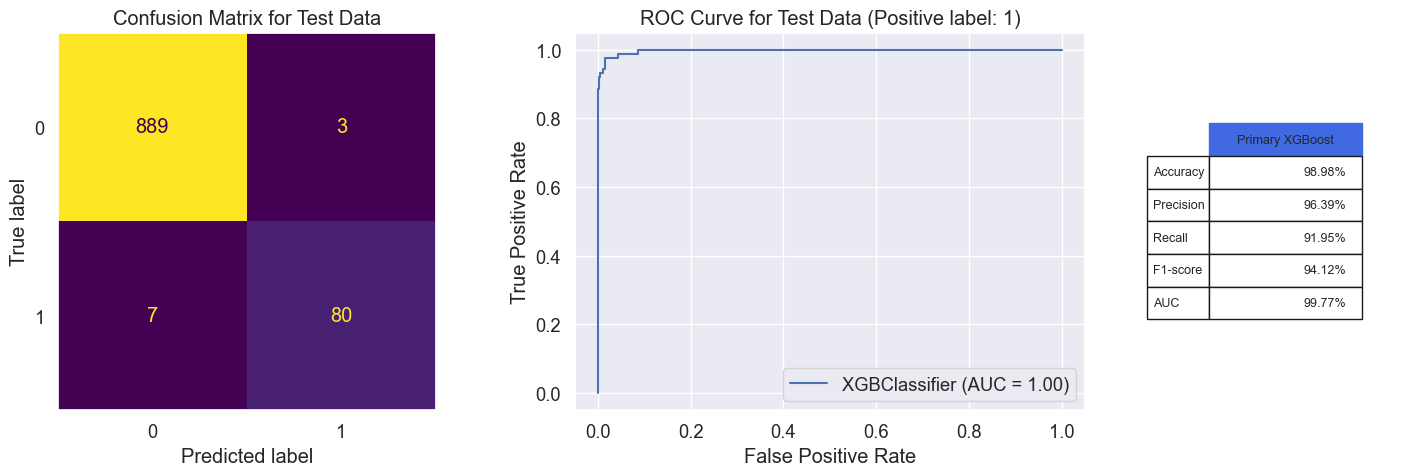

In [110]:
model_evaluation(xgb_opt, X_train, X_test, y_train, y_test, 'Primary XGBoost')

The XGBoost classifier is fairly overfitting on the minority class and the hyperparameters need to be adjusted to reduce the variance and prevent overfitting.

<h4 align="left"><font color='royalblue'>How to reduce our XGBoost classifier variance?</font></h4>

> * __min_child_weight:__ We can increase the value of min_child_weight to control the complexity of the tree model and prevent overfitting.
>
> * __max_depth:__ We can decrease the max_depth to prevent the model from learning too much from the training data and reduce model variance.
>
> * __gamma:__ We can increase the value of gamma to control the minimum loss reduction required to make a split in order to reduce model variance.
>
> * __lambda:__ We can increase the value of lambda to add regularization and control overfitting.
>
> * __subsample:__ We can decrease the value of subsample to reduce the number of samples used to fit each tree and reduce model variance.
>
> * __colsample_bytree:__ We can decrease the value of colsample_bytree to reduce the number of features used in each tree and avoid overfitting.
>
> * __n_estimators:__ we can increase the number of trees to reduce the variance of the model.

Among the optimal values obtained for hyperparameters, we only decrease the value of max_depth from 5 to 4 in order to partially avoid overfitting:

In [111]:
# Initialize the XGBoost Classifier
xgb_final = XGBClassifier(max_depth=4,
                          learning_rate=0.3,
                          n_estimators=200,
                          min_child_weight=1,
                          scale_pos_weight=1.5,
                          colsample_bytree=0.8,
                          gamma=0.1,
                          booster='gbtree',
                          objective='binary:logistic',
                          eval_metric='error', 
                          random_state=0)

# Train the XGBoost Classifier
xgb_final.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

Let's evaluate our final XGBoost classifier:


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3570
           1       1.00      1.00      1.00       346

    accuracy                           1.00      3916
   macro avg       1.00      1.00      1.00      3916
weighted avg       1.00      1.00      1.00      3916


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       892
           1       0.95      0.93      0.94        87

    accuracy                           0.99       979
   macro avg       0.97      0.96      0.97       979
weighted avg       0.99      0.99      0.99       979



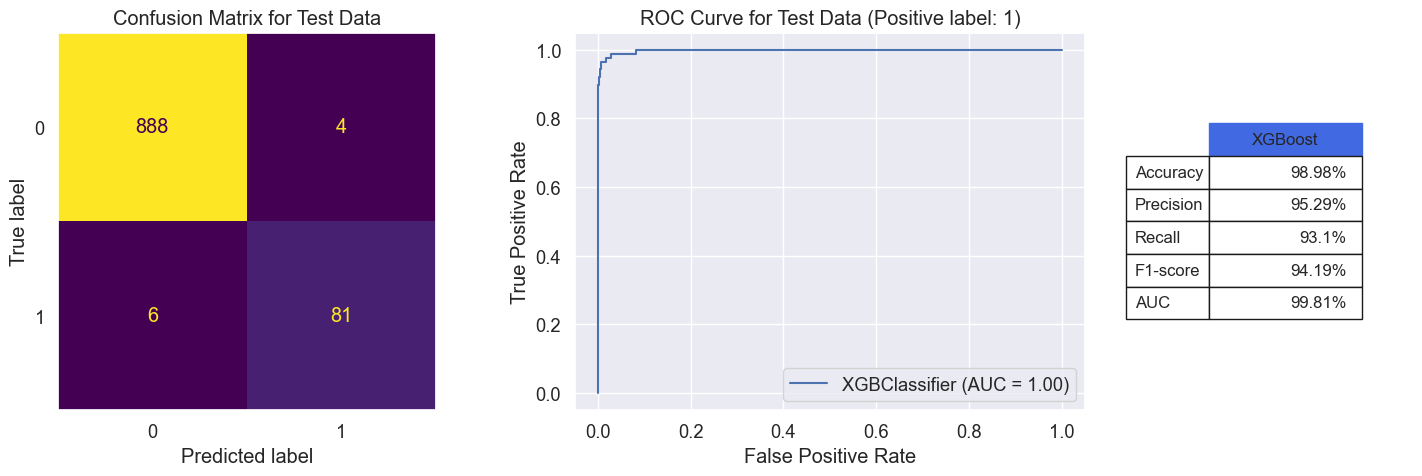

In [112]:
model_evaluation(xgb_final, X_train, X_test, y_train, y_test, 'XGBoost')

XGBoost classifier was our ultimate weapon to deal with our imbalanced dataset. As can be seen, we got the astonishing 94% f1-score with 99.81% AUC for our XGBoost classifier which is the best performance among all the classifiers reviewed. Out of 979 bank customers, the model made errors just in 10 cases to predict whether the customer accepts the loan or not.

In [113]:
# Save the final performance of XGBoost classifier
xgb_result = metrics_calculator(xgb_final, X_test, y_test, 'XGBoost')

__As we explained earlier, the most important metric for this project is the f1-score for class '1'. A high f1-score indicates a balance between identifying as many potential loan customers as possible (high recall) and minimizing the number of false positives (high precision), which is crucial for the bank to increase the conversion rate of depositors to borrowers while reducing the cost of the marketing campaign.__

Next, we can check the performance of all previous classifiers based on metrics:

In [115]:
# Concatenate previous classifiers perfermance results into a single dataframe
results = pd.concat([logreg_result, dt_result,rf_result, ada_result, gbc_result, xgb_result], axis=1).T

# Sort the dataframe in descending order based on F1-score values
results.sort_values(by='F1-score', ascending=False, inplace=True)

# Color the F1-score column
results.style.applymap(lambda x: 'background-color: royalblue', subset='F1-score')

,Accuracy,Precision,Recall,F1-score,AUC
AdaBoost,99.08%,97.56%,91.95%,94.67%,99.57%
Gradient Boosting,98.98%,95.29%,93.1%,94.19%,99.82%
XGBoost,98.98%,95.29%,93.1%,94.19%,99.81%
Random Forest,98.77%,96.3%,89.66%,92.86%,99.76%
Decision Tree,98.67%,94.05%,90.8%,92.4%,99.07%
Logistic Regression,94.89%,78.46%,58.62%,67.11%,96.27%


In the following, we can see the f1-score for class '1' of all previous classifiers in the form of a bar chart:

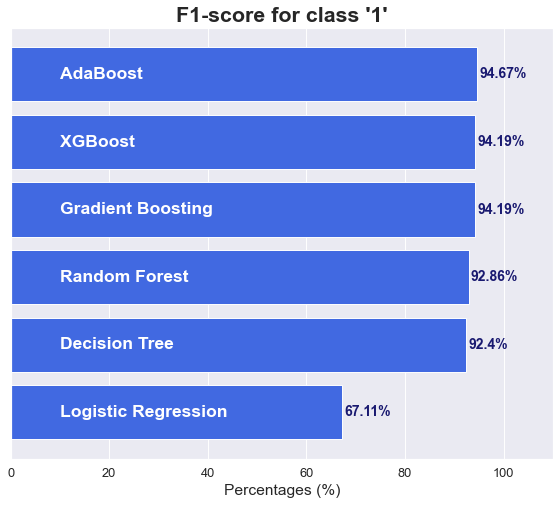

In [116]:
# Prepare values
results.sort_values(by='F1-score', ascending=True, inplace=True)
f1_scores = results['F1-score'].str.strip('%').astype(float)

# Plot the barh chart
fig, ax = plt.subplots(figsize=(10, 8), dpi=70)
ax.barh(results.index, f1_scores, color='royalblue')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(f1_scores, results.index)):
    ax.text(value+0.5, i, f"{value}%", ha='left', va='center', fontweight='bold', color='midnightblue')
    ax.text(10, i, name, ha='left', va='center', fontweight='bold', color='white', fontsize=18)

# Remove yticks
ax.set_yticks([])

# Set x-axis limit
ax.set_xlim([0,110])

# Add title and xlabel
plt.title("F1-score for class '1'", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

🏆 __Among all the tested classifiers, 'XGBoost Classifier' had the best performance in identifying potential loan customers:__

* __Accuracy = 99.49%__
* __F1-score = 97.08%__
* __Precision = 98.81%__
* __Recall = 95.4%__
* __AUC = 99.87%__


🏆 __Based on previous feature importance graphs, among all features, Education, Income, Family, CCAvg and CD Account play the most important role in identifying potential loan customers.__